In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/optiver_real_vol')

# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')


# !pip install plotly_express
# !pip install numba
# !pip install optuna
# !pip install shap

In [2]:
import cuml
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.preprocessing import OneHotEncoder as cuOneHotEncoder
import cudf
import numpy as np
import gc
import matplotlib.pyplot as plt
import os
import pickle
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from cuml.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import optuna
from optuna.trial import TrialState
from joblib import Parallel, delayed
from sklearn.preprocessing import OneHotEncoder
import plotly_express as px
import plotly.subplots as sub_plots
import plotly.graph_objects as go
import shap


import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cuml.internals.api_decorators")
warnings.filterwarnings("ignore", category=UserWarning, message="To use pickling first train using float32 data to fit the estimator")


/home/optimusprime/miniconda3/envs/cuml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import os
# import glob
# import pandas as pd

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# import pandas as pd
# import numpy as np
# import glob
# import os
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# import plotly.subplots as sub_plots
# import plotly.graph_objects as go
# import statsmodels.api as sm
# import scipy.stats as stats


# from sklearn.cluster import KMeans
# import re

# import warnings
# #warnings.filterwarnings("ignore")
# from sklearn.metrics import confusion_matrix
# #from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay


# from sklearn.utils import class_weight
# import optuna
# from optuna.trial import TrialState


# from mlxtend.evaluate import bias_variance_decomp
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# import glob
# import pandas as pd
# import numpy as np
# import glob
# import os
# from numba import jit, njit
# import numba as nb
# import plotly_express as px
# from itertools import combinations, permutations, product, combinations_with_replacement
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from scipy.signal import find_peaks
# import pickle
# from joblib import Parallel, delayed
# import seaborn as sns
# from sklearn import model_selection
# from sklearn.metrics import r2_score
# import gc
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans, AgglomerativeClustering
# from sklearn.mixture import GaussianMixture
# import scipy as sp
# from sklearn.metrics import silhouette_samples, silhouette_score
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.metrics import silhouette_samples, silhouette_score
# from sklearn.cluster import SpectralClustering, MiniBatchKMeans, MeanShift, AgglomerativeClustering
# from sklearn.mixture import GaussianMixture
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from scipy.spatial.distance import squareform
# from scipy.stats import skew, kurtosis
# import shap
# from datetime import datetime
# import ipywidgets as widgets
# from matplotlib.patches import Rectangle

# from sklearn.preprocessing import OneHotEncoder

# from sklearn.model_selection import RepeatedKFold, cross_val_score, TimeSeriesSplit
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.genmod.generalized_linear_model import GLM
# import warnings
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.utils import class_weight
# import optuna
# from optuna.trial import TrialState
# from mlxtend.evaluate import bias_variance_decomp
# import re

# from matplotlib.pyplot import cm


# from sklearn.manifold import TSNE
# from sklearn.preprocessing import minmax_scale

# from scipy.stats import spearmanr

## **Model Training**

In [4]:
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/Final_submission_data/partial_train_n_full_test')
#os.chdir('/content/drive/MyDrive/optiver_real_vol/Final Submission/kaggle_submission_versions')

with open('train_feat_df_reordered.pkl','rb') as f:
  train_feat_df_reordered = pickle.load(f)

with open('test_feat_df.pkl','rb') as f:
  test_feat_df = pickle.load(f)

#os.chdir('/content/drive/MyDrive/optiver_real_vol/kaggle/input/optiver-realized-volatility-prediction')

##### remove test from training data #####

df_train_reordered = train_feat_df_reordered.copy()
del train_feat_df_reordered

df_test = test_feat_df.copy()
del test_feat_df

## keep same data types
df_test['tlog_eps523_trade_price_n_wap1_dev'] = df_test['tlog_eps523_trade_price_n_wap1_dev'].astype('float64')
df_test['tlog_eps523_trade_price_n_wap_eqi_price0_dev'] = df_test['tlog_eps523_trade_price_n_wap_eqi_price0_dev'].astype('float64')

for c in df_train_reordered.columns:
    if 'float' in c:
        df_train_reordered[c] = df_train_reordered[c].astype('float32')

for c in df_test.columns:
    if 'float' in c:
        df_test[c] = df_test[c].astype('float32')

In [5]:

####################### Improvement 1 #######################
## # drop the bottom 25 xgb features
bottom_25_xgb_feat = ['tlog_tlog1p_eps1e4_range_bid_price1', 'bp_as_corr2', 'tlog_eps1e4_trade_price_std', 'v1liq2projt20', 'max_price1',
                     'max_bid_price2', 'max_ask_price2', 'bs_ap_corr2', 'min_price1', 'ask_lvl2_min_lvl1_size_feat', 'tlog_1p_trade_order_count_std',
                     'min_ask_price1', 'tlog_1p_trade_order_count_mean', 'min_bid_price2', 'lvl2_minus_lvl1_bid_n_ask_size_feat', 'bs_ap_corr1',
                     'liqt20rf29', 'as_ap_corr1', 'bp_as_corr1', 'as_ap_corr2', 'bs_bp_corr1', 'max_bid_price1', 'min_bid_price1', 'max_ask_price1']
df_train_reordered.drop(columns=bottom_25_xgb_feat, inplace=True)
df_test = df_test.drop(columns=bottom_25_xgb_feat, inplace=False)


####################### Improvement 2 #######################
## # drop these clusterings as they are least important clustering type
cluster_drop_cols = ['tlog_tlog1p_target_vol_sum_stats_4_clusters',
'tlog_tlog1p_target_vol_sum_stats_10_clusters',
'tlog_tlog1p_target_vol_sum_stats_16_clusters',
'tlog_tlog1p_target_vol_sum_stats_30_clusters',
'sum_stats_4_clusters_labels',
'sum_stats_10_clusters_labels',
'sum_stats_16_clusters_labels',
'sum_stats_30_clusters_labels']
df_train_reordered.drop(columns=cluster_drop_cols, inplace=True)
df_test = df_test.drop(columns=cluster_drop_cols, inplace=False)


####################### Improvement 3 #######################
## # Add shap. interaction terms
interaction_terms_list = [
('tlog_tlinear_sad_ask_size2', 'vol1_mean'),
('tlog_tlinear_sad_ask_size2', 'log_wap1_log_price_ret_vol'),
('tlog_tlinear_sad_size1', 'tlog_eps523_trade_price_n_wap_eqi_price0_dev'),
('tlog_tlinear_sad_size1', 'tlog_eps523_trade_price_n_wap1_dev'),
('tlog_eps523_trade_price_n_wap_eqi_price0_dev','log_wap1_log_price_ret_vol'),
('tlog_eps523_trade_price_n_wap_eqi_price0_dev', 'tlog_first_10_min_vol'),
('tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:20',
 'log_wap1_log_price_ret_vol'),
('tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:20',
 'tlog_first_10_min_vol'),
('tvpl2_rmed2v1', 'tlog_first_10_min_vol'),
('tvpl2_rmed2v1', 'log_wap1_log_price_ret_vol'),
('wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:0',
 'log_wap1_log_price_ret_vol'),
('wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:0',
 'tlog_first_10_min_vol'),
('wap1_log_price_ret_volstock_mean_from_25', 'log_wap1_log_price_ret_vol'),
('wap1_log_price_ret_volstock_mean_from_25', 'tlog_first_10_min_vol'),
('v1spprojt15f25_q1', 'log_wap1_log_price_ret_vol'),
('v1spprojt15f25_q1', 'tlog_first_10_min_vol'),
('soft_stock_mean_tvpl2_:20', 'wap1_log_price_ret_volstock_mean_from_25'),
('soft_stock_mean_tvpl2_:20', 'wap1_log_price_ret_volstock_mean_from_20'),
('tlog_target_vol_pcorr_3_clusters', 'soft_stock_mean_tvpl2_:20'),
('v1proj_29_15_q3', 'log_wap1_log_price_ret_vol'),
('v1proj_29_15_q3', 'tlog_first_10_min_vol'),
('root_trade_count_smean', 'tlog_first_10_min_vol'),
('root_trade_count_smean', 'log_wap1_log_price_ret_vol'),
('tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:20',
 'log_wap1_log_price_ret_vol'),
('tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:20',
 'tlog_first_10_min_vol'),
('wap1_log_price_ret_volstock_mean_from_20', 'log_wap1_log_price_ret_vol'),
('wap1_log_price_ret_volstock_mean_from_20', 'tlog_first_10_min_vol')]


## # create and add interaction terms to train and test set
for pair in interaction_terms_list:
    df_train_reordered[f'{pair[0]}_XXX_{pair[1]}'] = df_train_reordered[pair[0]] * df_train_reordered[pair[1]]
    df_test[f'{pair[0]}_XXX_{pair[1]}'] = df_test[pair[0]] * df_test[pair[1]]

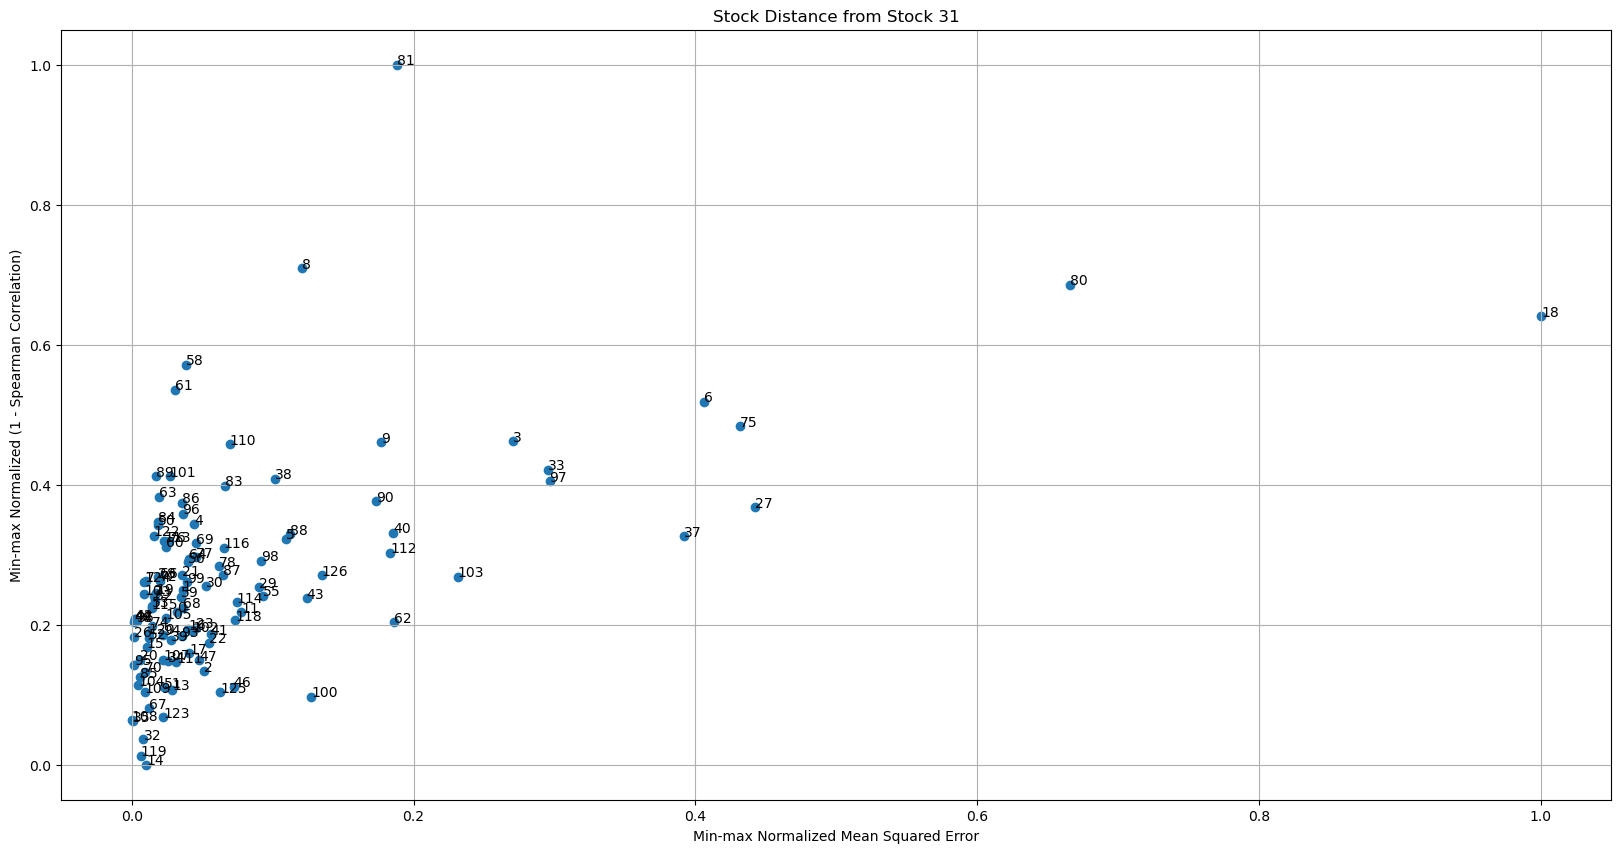

[(14, 0.01009101783901889),
 (119, 0.014168401580243904),
 (32, 0.03741445263985985),
 (35, 0.06193311142202087),
 (108, 0.06341247672773109),
 (123, 0.07127188083781733),
 (67, 0.08198003256470059),
 (109, 0.10404378818685812),
 (13, 0.11095662447992773),
 (51, 0.11314854112019265)]

In [6]:
####################### find stocks' target similar to stock 31 target in terms of MSE and Spearman correlation #######################
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')

full_train = pd.read_csv('train.csv')
full_train_31 = full_train[full_train['stock_id']==31]

distances_dict = {}

for stock in full_train['stock_id'].unique()[full_train['stock_id'].unique() != 31]:
    full_train_stock = full_train[full_train['stock_id']==stock]
    merged_df = pd.merge(full_train_31, full_train_stock, on='time_id', suffixes=('_31', f'_{stock}')).dropna()
    MSE = np.mean((merged_df['target_31'] - merged_df[f'target_{stock}'])**2)
    spearman_corr = 1 - spearmanr(merged_df['target_31'], merged_df[f'target_{stock}'])[0] # 1 - spearman correlation to get distance
    distances_dict[stock] = (MSE, spearman_corr)


mse_values = [value[0] for value in distances_dict.values()]
spearman_values = [value[1] for value in distances_dict.values()]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Reshape the data to fit the scaler
mse_values = np.array(mse_values).reshape(-1, 1)
spearman_values = np.array(spearman_values).reshape(-1, 1)
# Fit and transform the data
mse_values = scaler.fit_transform(mse_values).flatten()
spearman_values = scaler.fit_transform(spearman_values).flatten()

# Replace distances_dict values with standardized mse_values and spearman_values
for i, stock_id in enumerate(distances_dict.keys()):
    distances_dict[stock_id] = (mse_values[i], spearman_values[i])

stock_ids = list(distances_dict.keys())
plt.figure(figsize=(20, 10))
plt.scatter(mse_values, spearman_values)
for i, stock_id in enumerate(stock_ids):
    plt.annotate(stock_id, (mse_values[i], spearman_values[i]))
plt.xlabel('Min-max Normalized Mean Squared Error')
plt.ylabel('Min-max Normalized (1 - Spearman Correlation)')
plt.title('Stock Distance from Stock 31')
plt.grid(True)
plt.show()


# Calculate the magnitude (Euclidean distance) for each stock
magnitudes = {stock: np.sqrt(mse**2 + spearman**2) for stock, (mse, spearman) in distances_dict.items()}
# Sort the stocks by magnitude
sorted_stocks = sorted(magnitudes.items(), key=lambda item: item[1])
# Display the sorted stocks
sorted_stocks[:10]

In [7]:
####################### Improvement 4 #######################
## # create seperate training and testing dataframes for stock id 31 using the 5 most similar stocks to stock 31
####################### copy these similar stocks to a different dataframe #######################

similar_stocks = [] #[stock for stock, _ in sorted_stocks[:5]]  # 5 most similar stocks to stock 31
similar_stocks.append(31)  # add stock 31 to the list
similar_stocks = sorted(similar_stocks) # sort the list

df_train_reordered_for_stock_31 = df_train_reordered.copy()
df_test_for_stock_31 = df_test.copy()

df_train_reordered_for_stock_31 = df_train_reordered_for_stock_31[df_train_reordered_for_stock_31['stock_id'].isin(similar_stocks)]
df_test_for_stock_31 = df_test_for_stock_31[df_test_for_stock_31['stock_id'].isin(similar_stocks)]

In [8]:
####################### Improvement 5 #######################
## # drop stock id 31 from training set. 
df_train_reordered.drop(index=df_train_reordered[df_train_reordered['stock_id']==31].index, inplace=True)
df_test.drop(index=df_test[df_test['stock_id']==31].index, inplace=True)
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/Final_submission_data/partial_train_n_full_test')

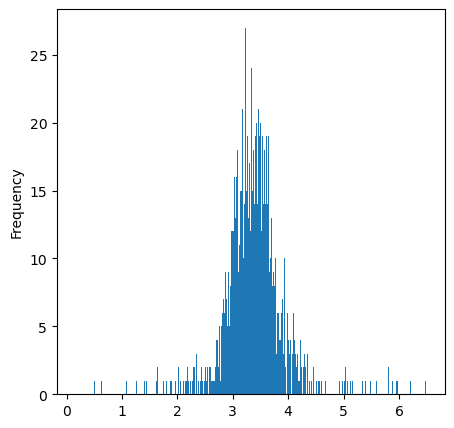

skew 0.22020589816296338
kurt 5.791218410646369


In [9]:
## check transformed target distribution
target_trans = (df_train_reordered_for_stock_31['target']/np.exp(df_train_reordered_for_stock_31['log_wap1_log_price_ret_vol']))
target_trans = np.log(target_trans) + 2
target_trans.plot(kind='hist', bins=1000, figsize=(5, 5))
plt.show()
print('skew',target_trans.skew())
print('kurt', target_trans.kurtosis())


In [10]:

class train_validate_n_test(object):

    def __init__(self,df_train_reordered, df_test) -> None:

        #self.time_id_order = df.loc[:3829,'time_id'].values # select ordered unique time_ids
        #self.train_time_id_ind = int(len(self.time_id_order)*0.7)

        largest_num_time_id_stock_idx = df_train_reordered.groupby('stock_id')['time_id'].apply(lambda x: x.nunique()).argmax()
        largest_num_time_id_stock = df_train_reordered['stock_id'].unique()[largest_num_time_id_stock_idx]
        self.time_id_order = df_train_reordered[df_train_reordered['stock_id'] == largest_num_time_id_stock]['time_id'].values # select reordered unique time_ids
        self.n_folds = 10
        folds = TimeSeriesSplit(n_splits=self.n_folds,)# max_train_size=None, gap=10)
        #self.splits = folds.split( range( self.train_time_id_ind ) ) # split 70% train time_ids into n_fold splits
        nunique_train_time_ids = df_train_reordered['time_id'].nunique()
        self.splits = folds.split( range( nunique_train_time_ids ) )

        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        #self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        #self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']
        self.train_stock_id = df_train_reordered['stock_id']
        self.train_time_id = df_train_reordered['time_id']

        # test_time_ids = self.time_id_order[self.train_time_id_ind:]
        # self.test_df = df[df['time_id'].isin(test_time_ids)]
        self.test_time_id = df_test[df_test['stock_id'] == largest_num_time_id_stock]['time_id'].values # select reordered unique time_ids
        self.test_df = df_test.dropna()
        self.test_stock_id = self.test_df['stock_id']
        self.test_time_id = self.test_df['time_id']

        #self.df = df
        self.df_train_reordered = df_train_reordered.dropna()

        # feature_importances = pd.DataFrame()
        cols = list(df_train_reordered.columns)
        cols.remove('tlog_target')
        cols.remove('target')
        cols.remove('time_id')
        self.feat_cols_list =  cols #cat_feat_labels+float32_feat_labels+float64_feat_labels # int32_feat_labels+int64_feat_labels+float32_feat_labels+float64_feat_labels
        # feature_importances['feature'] = self.feat_cols_list

        self.target_name = 'target' # _standardized' log target is easier to transform back than log_target_standardized
        self.target_shift = 2

        #del df
        del df_train_reordered,df_test
        gc.collect()

    # def onehotencode_cat_var(self,full_set):
    #     full_set = cat_feat_labels #full_set.astype({"stn_id":str,"block_id":str,"ts_of_day":str,"hr_of_day":str,"day_of_wk":str,"day_of_mn":str,"wk_of_mon":str })
    #     full_set = pd.get_dummies(full_set, prefix_sep="_",columns =cat_feat_labels,drop_first=True)
    #     #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)
    #     return full_set

    #### RMSPE cost function
    def rmspe(self,y_true, y_pred):
        return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


    # Custom RMSPE objective function
    def rmspe_objective(self,preds, dtrain):
        labels = dtrain.get_label()
        errors = (preds - labels) / labels
        gradient = 2 * errors / (1 + errors**2)
        hessian = 2 * (1 - errors**2) / (1 + errors**2)**2
        return gradient, hessian


    def RF_RMSPE(self,preds, train_data):
        labels = train_data.get_label()
        return 'RMSPE', round(self.rmspe(y_true = labels, y_pred = preds),5)


    def nancorr(self,a, b):
        v = np.isfinite(a)*np.isfinite(b) > 0
        return np.corrcoef(a[v], b[v])[0,1]


    def RF_train_validate(self, params, trial):
        rmspe_val_score = []

        for fold_n, (train_index, valid_index) in enumerate(self.splits):
            #print('Fold:', fold_n + 1)
            train_time_ids = self.time_id_order[train_index]
            val_time_ids = self.time_id_order[valid_index]

            # Convert to cuDF for GPU-accelerated processing
            train_df = cudf.DataFrame(self.df_train_reordered[self.df_train_reordered['time_id'].isin(train_time_ids)])
            val_df = cudf.DataFrame(self.df_train_reordered[self.df_train_reordered['time_id'].isin(val_time_ids)])

            X_train = train_df[self.feat_cols_list]
            y_train = train_df[self.target_name]
            X_valid = val_df[self.feat_cols_list]
            y_val = val_df[self.target_name]

            X_train['stock_id'] = X_train['stock_id'].astype('category')

            v1tr = np.exp(X_train['log_wap1_log_price_ret_vol'])
            v1v = np.exp(X_valid['log_wap1_log_price_ret_vol'])

            # Calculate weights and adjust the target
            w_train = y_train ** -2 * v1tr ** 2
            #weighted_y_train = (y_train / w_train).fillna(0)  # Adjust target values based on weights

            # Identify numeric and categorical features
            numeric_features = X_train.select_dtypes(include=['float64', 'int64', 'float32']).columns.tolist()
            categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

            # Encode categorical features using the same encoders
            encoded_categorical_dfs_train = []
            encoded_categorical_dfs_valid = []
            
            for cat_feature in categorical_features:
                encoder = LabelEncoder()
                encoded_feature_train = encoder.fit_transform(X_train[cat_feature])
                encoded_feature_valid = encoder.transform(X_valid[cat_feature])  # Use the same encoder

                encoded_categorical_dfs_train.append(encoded_feature_train)
                encoded_categorical_dfs_valid.append(encoded_feature_valid)

            # Concatenate numeric features and encoded categorical features for training
            transformed_X_train = cudf.concat([X_train[numeric_features]] + encoded_categorical_dfs_train, axis=1)
            transformed_X_train.columns = numeric_features + [f"{cat_feature}_encoded" for cat_feature in categorical_features]

            # Concatenate numeric features and encoded categorical features for validation
            transformed_X_valid = cudf.concat([X_valid[numeric_features]] + encoded_categorical_dfs_valid, axis=1)
            transformed_X_valid.columns = numeric_features + [f"{cat_feature}_encoded" for cat_feature in categorical_features]

            # Initialize and train the Random Forest Regressor
            model = cuRF(
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                max_features=params['max_features'],
                max_leaves=params['max_leaves'],
                random_state=42,
            )

            # Fit the model
            model.fit(transformed_X_train, (np.log(y_train / v1tr) + self.target_shift))

            # Make predictions
            y_val_pred = np.exp(model.predict(transformed_X_valid) - self.target_shift) * v1v

            # Calculate RMSPE for validation set
            rmspe_val = self.rmspe(y_val.to_pandas(), y_val_pred.to_pandas())  # convert back to pandas for compatibility
            rmspe_val_score.append(rmspe_val)

            #print(f'Fold: {fold_n + 1}, Validation RMSPE: {rmspe_val}')

        mean_rmspe_val_score = np.mean(rmspe_val_score)
        print(f'RMSPE validation score over {self.n_folds} splits is {rmspe_val_score}')
        print(f'Mean RMSPE validation score over {self.n_folds} splits is {mean_rmspe_val_score}')

        # # Plot the validation RMSPE scores
        # plt.figure(figsize=(10, 6))
        # plt.plot(range(1, len(rmspe_val_score) + 1), rmspe_val_score, marker='o', label='Validation RMSPE')
        # plt.title(f'Validation RMSPE Scores Across Folds (Trial: {trial.number})')
        # plt.xlabel('Fold Number')
        # plt.ylabel('RMSPE')
        # plt.xticks(range(1, len(rmspe_val_score) + 1))  # Set x-ticks to correspond to fold numbers
        # plt.grid(True)
        # plt.legend()
        # plt.show()

        del self.df_train_reordered, X_train, transformed_X_train, X_valid, y_train, y_val, train_df, val_df, v1tr, v1v
        gc.collect()

        return mean_rmspe_val_score



    def make_predictions(self, best_params):

        # Full training dataframe in cuDF for GPU processing
        full_train_df = cudf.DataFrame(self.df_train_reordered)

        X_train = full_train_df[self.feat_cols_list]
        y_train = full_train_df[self.target_name]  # target
        X_test = cudf.DataFrame(self.test_df[self.feat_cols_list])  # Convert test set to cuDF

        X_train['stock_id'] = X_train['stock_id'].astype('category')

        # Double exponential to nullify log
        v1tr = np.exp(X_train['log_wap1_log_price_ret_vol'])  
        v1ts = np.exp(X_test['log_wap1_log_price_ret_vol'])  

        w_train = y_train ** -2 * v1tr ** 2
        
        # Identify numeric and categorical features
        numeric_features = X_train.select_dtypes(include=['float64', 'int64', 'float32']).columns.tolist()
        categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

        # Encode categorical features using the same encoders
        encoded_categorical_train = []
        encoded_categorical_test = []

        for cat_feature in categorical_features:
            encoder = LabelEncoder()
            encoded_feature_train = encoder.fit_transform(X_train[cat_feature])
            encoded_feature_test = encoder.transform(X_test[cat_feature])  # Use the same encoder

            encoded_categorical_train.append(encoded_feature_train)
            encoded_categorical_test.append(encoded_feature_test)

        # Concatenate numeric features and encoded categorical features for training
        transformed_X_train = cudf.concat([X_train[numeric_features]] + encoded_categorical_train, axis=1)
        transformed_X_train.columns = numeric_features + [f"{cat_feature}_encoded" for cat_feature in categorical_features]

        # Concatenate numeric features and encoded categorical features for test
        transformed_X_test = cudf.concat([X_test[numeric_features]] + encoded_categorical_test, axis=1)
        transformed_X_test.columns = numeric_features + [f"{cat_feature}_encoded" for cat_feature in categorical_features]

        print('Final model')
        
        # Initialize and train the Random Forest Regressor
        model = cuRF(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            max_leaves=best_params['max_leaves'],
            random_state=42,
        )

        # Train the model directly (no weights applied)
        model.fit(transformed_X_train, np.log(y_train / v1tr) + self.target_shift)

        # Make predictions
        train_pred = np.exp(model.predict(transformed_X_train) - self.target_shift) * v1tr
        test_pred = np.exp(model.predict(transformed_X_test) - self.target_shift) * v1ts

        del full_train_df  # Clean up
        gc.collect()

        return model, train_pred, test_pred, y_train.to_pandas(), X_train.to_pandas(), X_test.to_pandas(), v1tr, v1ts,w_train, self.target_name



    def local_manual_shapley_additivity_check(self,model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name):

        y_train_true = all_stock_y_train_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        model_pred = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
                #### ONLY for Explainer
        shap_pred = ( shap_values.base_values + shap_values.values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

                #### ONLY for TreeExplainer
        #shap_pred = ( model_base_value + shap_values.sum(axis=1) )* all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]

        #print('shap_values.sum(axis=1)',shap_values.sum(axis=1))
        # print('shap_values.base_values',shap_values.base_values[0])
        # print('shap_values.values',shap_values.values[0].sum())
        #print('len(shap_values.values.sum(axis=1))',len(shap_values.values.sum(axis=1)))

        model_shap_rmspe = self.rmspe(model_pred, shap_pred)

        fig, ax = plt.subplots(2,1,figsize=(30,10))
        ax[0].plot(np.arange(0,len(y_train_true)),y_train_true,label='true rvol.',linestyle='dashed',c='g',marker='*',alpha=0.2)
        ax[0].plot(np.arange(0,len(model_pred)),model_pred,label='model prediction',linestyle='dashed',c='b',marker='*',alpha=0.6)
        ax[0].set_title(f'True Rvol. Vs. model predicted Rvol.' )
        ax[0].text(0,0.01,f"stock_id: {stock_id}, view_time_ids_start: {view_time_ids_start}, view_time_ids_end:{view_time_ids_end}")
        ax[0].set_ylabel('rvol.')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].plot(np.arange(0,len(model_pred)),model_pred,label='model prediction',linestyle='dashed',c='b',marker='*',alpha=0.4)
        ax[1].plot(np.arange(0,len(shap_pred)),shap_pred,label='summed shap values prediction',linestyle='dashed',c='r',marker='*',alpha=0.4)
        ax[1].set_title(f'Check additivity of shap values, RMSPE:{model_shap_rmspe} between model and shap values prediction' )
        ax[1].text(0,0.01,f"stock_id: {stock_id}, view_time_ids_start: {view_time_ids_start}, view_time_ids_end:{view_time_ids_end}")
        ax[1].set_ylabel('rvol.')
        ax[1].legend()
        ax[1].grid(True)
        fig.tight_layout()
        fig.show()


        del all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values
        gc.collect()
        return


    def compute_shapley_PDP_n_Scatter(self,feature_name,shap_values,groundtruth,prediction,stock_id,view_time_ids_start,view_time_ids_end,set_name):
        ####### compute partial dependence plot of most important features

        ###### Partial dependence plot
        #fig,ax = plt.subplots()
        #shap.plots.partial_dependence(feature_name, model.predict, RF.DMatrix(X_train,enable_categorical=True), model_expected_value=True, feature_expected_value=True)
        #fig.show()

        ##### scatter plot
        print(f'\n scatter plot of {feature_name} vs. shap values')
        print(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')

        fig, ax = plt.subplots(2, 2, figsize=(20, 20))
        inds = shap.utils.potential_interactions(shap_values[:, feature_name], shap_values)
        shap.plots.scatter(shap_values[:, feature_name], color=shap_values[:, inds[0]], title=f'scatter plot of {feature_name} Vs. Shap values on {set_name} set', ax=ax[0, 0])
        shap.plots.scatter(shap_values[:, feature_name], color=shap_values[:, inds[1]], ax=ax[0, 1])
        shap.plots.scatter(shap_values[:, feature_name], color=shap_values[:, inds[2]], ax=ax[1, 0])
        plt.show()

        error = groundtruth['target'] - prediction['target']
        ##### scatter plot of feature shap values vs. error
        fig, ax = plt.subplots(figsize=(5, 5))
        print(f'\n scatter plot of {feature_name} shap values vs. error')
        print(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        ax.scatter(error.values,shap_values[:, feature_name].values, alpha=0.4 )
        ax.set_xlabel('error')
        ax.set_ylabel(f'{feature_name} shap values')
        ax.grid()
        ax.set_title(f'scatter plot of {feature_name} shap values Vs. error on {set_name} set')
        plt.tight_layout()
        plt.show()


        ##### scatter plot of feature vs. True target rvol. on trianing set
        # fig,ax = plt.subplots()
        # yval = all_stock_y_train_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # xval = X[feature_name]
        # ax.scatter(xval,yval)
        # ax.plot([min(xval), max(xval)], [min(yval),max(yval)], color = 'red', linewidth = 1)
        # ax.set_xlabel(feature_name)
        # ax.set_ylabel('True target rvol.')
        # ax.grid
        # ax.set_title(f'scatter plot of {feature_name} Vs. True Rvol. for stock_id: {stock_id}, from {view_time_ids_start} to {view_time_ids_end}')
        # fig.show()


        ##### scatter plot of feature vs. predicted target rvol.on trianing set
        # fig,ax = plt.subplots()
        # yval1 = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # ax.scatter(xval,yval1)
        # ax.plot([min(xval), max(xval)], [min(yval1),max(yval1)], color = 'red', linewidth = 1)
        # ax.set_xlabel(feature_name)
        # ax.set_ylabel('Predicted target rvol.')
        # ax.grid
        # ax.set_title(f'scatter plot of {feature_name} Vs. Predicted Rvol. for stock_id: {stock_id}, from {view_time_ids_start} to {view_time_ids_end}')
        # fig.show()


        del shap_values
        gc.collect()
        return



    def compute_shapley_beeswarm(self,shap_values,top_n_feat,stock_id,view_time_ids_start,view_time_ids_end,set_name):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # shap.summary_plot(shap_values)
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        ax.set_title(f'Beeswarm plot for {set_name} set showing top {top_n_feat} features')
        shap.plots.beeswarm(shap_values, max_display=top_n_feat)
        #ax.set_title(f' stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        plt.show()

        del all_stock_v1tr_df,shap_values
        gc.collect()
        return



    def compute_shapley_barplot(self,shap_values,top_n_feats,X,Y,stock_id,view_time_ids_start,view_time_ids_end,set_name):

        #### ONLY for TreeExplainer
        # plt.figure()
        # stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # shap_values = np.multiply(shap_values.T ,stock_v1tr_df).T
        # plt.bar(shap_values.abs().sum(axis=1))
        # plt.title(f'stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # plt.show()

        #### ONLY for Explainer
        print(f'\nMEAN ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        ax.set_title(f'MEAN ABSOLUTE of feature bar plot on {set_name} set showing top {top_n_feats} features')
        #clustering = shap.utils.hclust(X,Y)
        shap.plots.bar(shap_values, max_display=top_n_feats)#,clustering=clustering,clustering_cutoff=0.9)
        #ax.title(f'MEAN ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()


        #### ONLY for Explainer
        print(f'\nMAXIMUM ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        #clustering = shap.utils.hclust(X,Y)
        ax.set_title(f'MAXIMUM ABSOLUTE of feature bar plot on {set_name} set showing top {top_n_feats} features')
        shap.plots.bar(shap_values.abs.max(0), max_display=top_n_feats)#,clustering=clustering,clustering_cutoff=0.9)
        #ax.title(f'nMAXIMUM ABSOLUTE of feature bar plot \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values, X,Y,stock_id,view_time_ids_start,view_time_ids_end,set_name,fig,ax,top_n_feats
        gc.collect()
        return


    def compute_individual_stock_SHAP_values(self,final_reg,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name,stock_id,view_time_ids_start,view_time_ids_end):

        # plot shapley feature importances for all samples
        final_reg.set_param({"device": "cuda"})
        shap.initjs()

        stock_id = stock_id
        view_time_ids_start = view_time_ids_start
        view_time_ids_end = view_time_ids_end
        X = X_train[X_train['stock_id'].isin([stock_id])].iloc[view_time_ids_start:view_time_ids_end]

        ###### Explainer #######
        #explainer = shap.Explainer(final_reg,X)
        explainer = shap.TreeExplainer(final_reg, feature_perturbation="tree_path_dependent")
        shap_values = explainer(np.array(X),check_additivity=False)
        shap_values.feature_names = final_reg.feature_names

        ###### TreeExplainer #######
        # explainer = shap.TreeExplainer(final_reg,feature_perturbation='interventional')
        # shap_values = explainer.shap_values(np.array(X),check_additivity=False)
        # shap_values.feature_names = final_reg.feature_names

        model_base_value = explainer.expected_value
        # print(f'Model base value: {model_base_value} before scaling by v1tr')

        ####### GLOBAL ALL feature contributions ##############################
        ###### Do manual additivity check because it fails
        self.local_manual_shapley_additivity_check(model_base_value,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,shap_values,stock_id,view_time_ids_start,view_time_ids_end,feature_name )

        ####### Manually correct the shap values to accomodate v1tr scaling
        shap_values.base_values = shap_values.base_values * all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end] # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        stock_v1tr_df = all_stock_v1tr_df[stock_id].values[view_time_ids_start:view_time_ids_end] # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        shap_values.values = np.multiply(shap_values.values.T ,stock_v1tr_df).T
        ###### check correctness of shap_values
        # sp = shap_values.base_values + shap_values.values.sum(axis=1)
        # plt.figure(figsize=(30,5))
        # plt.plot(range(len(sp)),sp)
        # model_pred = all_stock_train_pred_df[stock_id].values[view_time_ids_start:view_time_ids_end]
        # plt.plot(range(len(sp)), model_pred )
        # plt.show()

        self.compute_shapley_beeswarm(X,shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        #shap_values = final_reg.predict(dtrain, pred_contribs=True)
        ### Calculate SHAP values for a specific instance (e.g., the first test instance)
        ### shap_values = explainer.shap_values(X_test.iloc[0])

        self.compute_shapley_barplot(shap_values,all_stock_v1tr_df,stock_id,view_time_ids_start,view_time_ids_end)

        self.compute_shapley_heatmap(shap_values,stock_id,view_time_ids_start,view_time_ids_end,all_stock_train_pred_df)

        ####### INDIVIDUAL feature contributions ##############################
        ####### compute partial dependence plot of most important features
        self.compute_shapley_PDP_n_Scatter(feature_name,shap_values,stock_id,view_time_ids_start,view_time_ids_end,X,all_stock_y_train_df,all_stock_train_pred_df)

        #self.compute_shapley_decision(model_base_value,shap_values.data,shap_values.feature_names,stock_id,view_time_ids_start,view_time_ids_end)

        ##### force plot has some error
        #self.compute_shapley_force(model_base_value,shap_values.data,X,shap_values.feature_names,stock_id,view_time_ids_start,view_time_ids_end)


        del final_reg,X_train
        gc.collect()
        return



    def identiy_largest_overall_n_under_n_over_prediction_errors(self,groundtruth,prediction,set_name):

        # overall error
        oveall_error = groundtruth['target'] - prediction['target']
        # overall squared percentage error
        ovearll_SPE = pd.DataFrame()
        ovearll_SPE['target_spe'] = (oveall_error / groundtruth['target'] )**2
        ovearll_SPE['stock_id'] = groundtruth['stock_id']
        ovearll_SPE['time_id'] = groundtruth['time_id']

        # sort the overall_SPE by descending order
        top_n_instances = 50
        sorted_ovearll_SPE = ovearll_SPE.sort_values('target_spe',ascending=False)[:top_n_instances].reset_index(drop=True)
        # Plot the sorted_ovearll_SPE as a bar plot with dual x-axis for stock_id and time_id
        fig, ax1 = plt.subplots(figsize=(15, 8))
        # Plotting the bar graph for 'target_spe'
        ax1.bar(sorted_ovearll_SPE.index, sorted_ovearll_SPE['target_spe'], color='b', alpha=0.6)
        ax1.set_xlabel('Instance Index')
        ax1.set_ylabel('Target Squared Percentage Error', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        # Creating a twin Axes sharing the x-axis
        ax2 = ax1.twiny()
        # Setting the x-ticks and labels for stock_id and time_id
        ax2.set_xticks(sorted_ovearll_SPE.index)
        ax2.set_xticklabels(sorted_ovearll_SPE['stock_id'], rotation=90, ha='center')
        ax2.set_xlabel('Stock ID')
        # Creating another twin Axes sharing the x-axis
        ax3 = ax1.twiny()
        # Offset the twin axis below the original x-axis
        ax3.spines['top'].set_position(('outward', 40))
        ax3.set_xticks(sorted_ovearll_SPE.index)
        ax3.set_xticklabels(sorted_ovearll_SPE['time_id'], rotation=90, ha='center')
        ax3.set_xlabel('Time ID')
        plt.title(f'{top_n_instances} Largest Target SPE instances with Stock ID and Time ID on ' + set_name + ' Set')
        plt.show()

        overall_RMSPE = np.sqrt(np.mean(ovearll_SPE['target_spe']))
        corrected_overall_SPE = ovearll_SPE.sort_values('target_spe',ascending=False)[top_n_instances:].reset_index(drop=True)
        corrected_overall_RMSPE = np.sqrt(np.mean(corrected_overall_SPE['target_spe']))
        print(f'\nOverall RMSPE: {overall_RMSPE} on {set_name} set')
        print(f'Corrected RMSPE: {corrected_overall_RMSPE} on {set_name} set')
        print(f'Percentage improvment in RMSPE of ovearall error on {set_name} set after correcting the top {top_n_instances} instances:')
        print(f'{(overall_RMSPE - corrected_overall_RMSPE )/overall_RMSPE*100}%')


        # underprediction squared percentage error
        up_SPE = ovearll_SPE[oveall_error > 0].reset_index(drop=True)
        # sort the up_SPE by descending order
        sorted_up_SPE = up_SPE.sort_values('target_spe',ascending=False)[:top_n_instances].reset_index(drop=True)
        # Plot the sorted_up_SPE as a bar plot with dual x-axis for stock_id and time_id
        fig, ax1 = plt.subplots(figsize=(15, 8))
        # Plotting the bar graph for 'target_spe'
        ax1.bar(sorted_up_SPE.index, sorted_up_SPE['target_spe'], color='b', alpha=0.6)
        ax1.set_xlabel('Instance Index')
        ax1.set_ylabel('Target Squared Percentage Error', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        # Creating a twin Axes sharing the x-axis
        ax2 = ax1.twiny()
        # Setting the x-ticks and labels for stock_id and time_id
        ax2.set_xticks(sorted_up_SPE.index)
        ax2.set_xticklabels(sorted_up_SPE['stock_id'], rotation=90, ha='center')
        ax2.set_xlabel('Stock ID')
        # Creating another twin Axes sharing the x-axis
        ax3 = ax1.twiny()
        # Offset the twin axis below the original x-axis
        ax3.spines['top'].set_position(('outward', 40))
        ax3.set_xticks(sorted_up_SPE.index)
        ax3.set_xticklabels(sorted_up_SPE['time_id'], rotation=90, ha='center')
        ax3.set_xlabel('Time ID')
        plt.title(f'{top_n_instances} Largest target SPE Underprediction instances with Stock ID and Time ID on ' + set_name + ' Set')
        plt.show()

        up_RMSPE = np.sqrt(np.mean(up_SPE['target_spe']))
        corrected_up_SPE = up_SPE.sort_values('target_spe',ascending=False)[top_n_instances:].reset_index(drop=True)
        corrected_up_RMSPE = np.sqrt(np.mean(corrected_up_SPE['target_spe']))
        print(f'\nUnderprediction RMSPE: {up_RMSPE} on {set_name} set')
        print(f'Corrected Underprediction RMSPE: {corrected_up_RMSPE} on {set_name} set')
        print(f'Percentage improvment in RMSPE of underprediction error on {set_name} set after correcting the top {top_n_instances} instances:')
        print(f'{(up_RMSPE - corrected_up_RMSPE )/up_RMSPE*100}%')


        # overprediction squared percentage error
        op_SPE = ovearll_SPE[oveall_error < 0].reset_index(drop=True)
        # sort the op_SPE by descending order
        sorted_op_SPE = op_SPE.sort_values('target_spe',ascending=False)[:top_n_instances].reset_index(drop=True)
        # Plot the sorted_op_SPE as a bar plot with dual x-axis for stock_id and time_id
        fig, ax1 = plt.subplots(figsize=(15, 8))
        # Plotting the bar graph for 'target_spe'
        ax1.bar(sorted_op_SPE.index, sorted_op_SPE['target_spe'], color='b', alpha=0.6)
        ax1.set_xlabel('Instance Index')
        ax1.set_ylabel('Target Squared Percentage Error', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        # Creating a twin Axes sharing the x-axis
        ax2 = ax1.twiny()
        # Setting the x-ticks and labels for stock_id and time_id
        ax2.set_xticks(sorted_op_SPE.index)
        ax2.set_xticklabels(sorted_op_SPE['stock_id'], rotation=90, ha='center')
        ax2.set_xlabel('Stock ID')
        # Creating another twin Axes sharing the x-axis
        ax3 = ax1.twiny()
        # Offset the twin axis below the original x-axis
        ax3.spines['top'].set_position(('outward', 40))
        ax3.set_xticks(sorted_op_SPE.index)
        ax3.set_xticklabels(sorted_op_SPE['time_id'], rotation=90, ha='center')
        ax3.set_xlabel('Time ID')
        plt.title(f'{top_n_instances} Largest target SPE Overprediction instances with Stock ID and Time ID on ' + set_name + ' Set')
        plt.show()

        op_RMSPE = np.sqrt(np.mean(op_SPE['target_spe']))
        corrected_op_SPE = op_SPE.sort_values('target_spe',ascending=False)[top_n_instances:].reset_index(drop=True)
        corrected_op_RMSPE = np.sqrt(np.mean(corrected_op_SPE['target_spe']))
        print(f'\nOverprediction RMSPE: {op_RMSPE} on {set_name} set')
        print(f'Corrected Overprediction RMSPE: {corrected_op_RMSPE} on {set_name} set')
        print(f'Percentage improvment in RMSPE of overprediction error on {set_name} set after correcting the top {top_n_instances} instances:')
        print(f'{(op_RMSPE - corrected_op_RMSPE )/op_RMSPE*100}%')


        ovearll_error_idxs = []
        up_error_idxs = []
        op_error_idxs = []
        for i in range(top_n_instances):
            ovearll_error_idxs.append(groundtruth[(groundtruth['stock_id'] == sorted_ovearll_SPE['stock_id'][i]) & (groundtruth['time_id'] == sorted_ovearll_SPE['time_id'][i])].index[0])
            up_error_idxs.append(groundtruth[(groundtruth['stock_id'] == sorted_up_SPE['stock_id'][i]) & (groundtruth['time_id'] == sorted_up_SPE['time_id'][i])].index[0])
            op_error_idxs.append(groundtruth[(groundtruth['stock_id'] == sorted_op_SPE['stock_id'][i]) & (groundtruth['time_id'] == sorted_op_SPE['time_id'][i])].index[0])

        return ovearll_error_idxs, up_error_idxs, op_error_idxs



    def shapley_analysis_of_large_error_instances(self,ovearll_error_idxs, up_error_idxs, op_error_idxs,shap_values_all,set_name):

        print('shap_values_all.feature_names',len(shap_values_all.feature_names))

        # decision plot of the largest overall error instances
        display_n_features = 40
        fig, ax = plt.subplots(figsize=(50,10))
        shap.decision_plot(np.mean(shap_values_all.base_values[ovearll_error_idxs]), shap_values_all.values[ovearll_error_idxs,:], \
                           feature_names=shap_values_all.feature_names, feature_order='importance', feature_display_range= slice(-1,-display_n_features,-1),\
                           title=f'Decision plot of the {display_n_features} largest overall error instances on {set_name} set \n (ignore the WRONG expected value shown)')
        plt.show()

        # decision plot of the largest overprediction error instances
        fig, ax = plt.subplots(figsize=(50,10))
        shap.decision_plot(np.mean(shap_values_all.base_values[op_error_idxs]), shap_values_all.values[op_error_idxs,:], \
                            feature_names=shap_values_all.feature_names, feature_order='importance', feature_display_range= slice(-1,-30,-1),\
                            title=f'Decision plot of the {display_n_features} largest overprediction error instances on {set_name} set \n (ignore the WRONG expected value shown)')
        plt.show()

        # decision plot of the largest underprediction error instances
        fig, ax = plt.subplots(figsize=(50,10))
        shap.decision_plot(np.mean(shap_values_all.base_values[up_error_idxs]), shap_values_all.values[up_error_idxs,:], \
                            feature_names=shap_values_all.feature_names, feature_order='importance', feature_display_range= slice(-1,-30,-1),\
                            title=f'Decision plot of the {display_n_features} largest underprediction error instances on {set_name} set \n (ignore the WRONG expected value shown)')
        plt.show()

        del shap_values_all,ovearll_error_idxs, up_error_idxs, op_error_idxs,set_name
        return



    def compute_global_SHAP_values(self,final_reg,X_train,y_train,train_pred,v1tr,set_name):

        print(f'\nGround-Truth Rvol. grand average on {set_name} set: {y_train["target"].values.mean()}')
        print(f'\nModel Prediction Rvol. grand average on {set_name} set: {train_pred["target"].values.mean()}')

        # plot shapley feature importances for all samples
        final_reg.set_param({"device": "cuda"})
        shap.initjs()

        X = X_train

        ###### Explainer #######
        #explainer = shap.Explainer(final_reg,X)
        explainer = shap.TreeExplainer(final_reg, feature_perturbation="tree_path_dependent")
        shap_values_all = explainer(np.array(X),check_additivity=False)
        shap_values_all.feature_names = final_reg.feature_names

        model_base_value = explainer.expected_value

        ####### GLOBAL ALL feature contributions ##############################
        ###### Do manual additivity check because it fails
        self.global_manual_shapley_additivity_check(train_pred,v1tr,shap_values_all,set_name)

        ####### Manually correct the shap values to accomodate v1tr scaling
        shap_values_all.base_values = shap_values_all.base_values * v1tr['wap1_log_price_ret_vol'].values  # all_stock_v1tr_df.iloc[view_time_ids_start:view_time_ids_end,stock_id].values
        shap_values_all.values = np.multiply(shap_values_all.values.T ,v1tr['wap1_log_price_ret_vol'].values).T

        ###### Beeswarm plot
        #### ONLY for Explainer
        print(f'\n Global Beeswarm plot for all stock ids and time ids')
        top_n_feat = 25
        self.compute_shapley_beeswarm(shap_values_all,top_n_feat,stock_id=None,view_time_ids_start=None,view_time_ids_end=None,set_name=set_name)

        ###### Bar plot MEAN Absolute value of features
        #### ONLY for Explainer
        print(f'\nMEAN ABSOLUTE of feature bar plot for all stock ids and time ids')
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values_all)# clustering=clustering)
        #ax.title(f'MEAN ABSOLUTE of feature bar plot for all stock ids and time ids')

        ###### Bar plot MAXIMUM Absolute value of features
        #### ONLY for Explainer
        print(f'\nMAXIMUM ABSOLUTE of feature bar plot for all stock ids and time ids')
        #clustering = shap.util.hclust(X,y)
        shap.plots.bar(shap_values_all.abs.max(0), )#clustering=clustering)
        #ax.title(f'nMAXIMUM ABSOLUTE of feature bar plot for all stock ids and time ids')

        del final_reg,X_train,y_train,train_pred,v1tr
        gc.collect()
        return shap_values_all


    def global_manual_shapley_additivity_check(self,train_pred,v1tr,shap_values_all, set_name):
        #### ONLY for Explainer
        shap_pred_all = ( shap_values_all.base_values + shap_values_all.values.sum(axis=1) ) * v1tr['wap1_log_price_ret_vol'] #pd.DataFrame(all_stock_v1tr_df.values.ravel() , columns=['v1tr_all'])['v1tr_all'].values
        model_shap_rmspe_all = self.rmspe(train_pred['target'], shap_pred_all)

        # # line plot of model prediction vs. shap values prediction
        # fig, ax = plt.subplots(figsize=(30,10))
        # ax.plot(np.arange(0,len(train_pred['target'])),train_pred['target'],label='prediction',linestyle='dashed',c='g',marker='*',alpha=0.2)
        # ax.plot(np.arange(0,len(shap_pred_all)),shap_pred_all,label='shap_value',linestyle='dashed',c='b',marker='*',alpha=0.6)
        # ax.set_title(f'Model prediction Vs. Shap_values for additivity check on {set_name} set' )
        # ax.set_ylabel('rvol.')
        # ax.legend()
        # ax.grid(True)
        # plt.show()
        # plt.close()

        # scatter plot of model prediction vs. shap values prediction
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(train_pred['target'],shap_pred_all)
        ax.plot([min(train_pred['target']), max(train_pred['target'])], [min(shap_pred_all),max(shap_pred_all)], color = 'red', linewidth = 1)
        ax.set_xlabel('model prediction')
        ax.set_ylabel('shap prediction')
        ax.grid
        ax.set_title(f'scatter plot of model prediction Vs. shap prediction on {set_name} set')
        plt.show()
        plt.close()

        print(f'\n Check Additivity of shap values in all stock and time ids, model_shap_rmspe_all: {model_shap_rmspe_all} on {set_name} set')
        del train_pred,v1tr,shap_values_all
        gc.collect()
        return




    def analyze_global_SHAP_values(self,shap_values_all,groundtruth, prediction,set_name):

        ###################################### All Error vs. feature Shapley values Analysis #######################################
        ## filter out features that have high negative and positively shapley values and see if they are correlated with the error

        top_largest_shap_val_feat = 100
        error = groundtruth['target'] - prediction['target']
        # select only the features that have high shapley values over all instances/samples
        abs_summed_shap = np.abs(shap_values_all.values).sum(axis=0)
        sorted_summed_shap = np.sort(abs_summed_shap)[::-1]
        labels = np.array(shap_values_all.feature_names)[np.argsort(abs_summed_shap)[::-1]]
        top_n_feat = 50
        print(f'\nTop {top_n_feat} features based on summed absolute SHAP values over ALL instances/samples on {set_name} set')
        print(list(labels[:top_n_feat]))
        bot_n_feat = 25
        print(f'Bottom {bot_n_feat} features based on summed absolute SHAP values over ALL instances/samples on {set_name} set')
        print(list(labels[-bot_n_feat:]))

        # from the features that have high shapley values over all instances/samples
        # find out feature shapley values that are negatively correlated with the error
        feat_error_corr_dict = {}
        for feat in labels[:top_largest_shap_val_feat]:
            # if self.nancorr(shap_values_all.values[:,shap_values_all.feature_names.index(feat)], error) < 0:
            #     feat_error_corr_dict[feat] = self.nancorr(shap_values_all.values[:,shap_values_all.feature_names.index(feat)], error)
            corr, _ = spearmanr(shap_values_all.values[:, shap_values_all.feature_names.index(feat)], error)
            if corr < 0:
                feat_error_corr_dict[feat] = corr

        # sort the features based on the most negative correlation with the error first
        sorted_feat_error_corr_dict = dict(sorted(feat_error_corr_dict.items(), key=lambda item: item[1]))

        # scatter plot of features shapley values vs. error over all instances/samples for the top_n_feat features that have high negative correlation with the error
        top_n_feat = 28
        fig, ax = plt.subplots(int(top_n_feat/4), 4, figsize=(30, 30))
        fig.suptitle(f"{set_name} set", fontsize=16)
        for feat in list(sorted_feat_error_corr_dict.keys())[:top_n_feat]:
            ax.flatten()[list(sorted_feat_error_corr_dict.keys()).index(feat)].scatter(shap_values_all.values[:,shap_values_all.feature_names.index(feat)], error, alpha=0.1)
            ax.flatten()[list(sorted_feat_error_corr_dict.keys()).index(feat)].set_title(f"{feat} shap values vs. error \n, spear. corr: {sorted_feat_error_corr_dict[feat]}")
            ax.flatten()[list(sorted_feat_error_corr_dict.keys()).index(feat)].set_xlabel('error')
        fig.tight_layout()
        plt.show()

        print(f'\nTop {top_n_feat} features that have high negative correlation with the error on {set_name} set')
        print(list(sorted_feat_error_corr_dict.keys())[:top_n_feat])


        ###################################### Underprediction Error Shapley Analysis #######################################
        ## filter out instance where underpreidction is happening, then identfy the features that are causing the underprediction
        ## do not identfiy the features on the entire dataset.

        top_n_feat = 50
        underprediction = prediction['target'] < groundtruth['target']

        abs_summed_shap = np.abs(shap_values_all.values[underprediction]).sum(axis=0)
        sorted_summed_shap = np.sort(abs_summed_shap)[::-1]
        labels = np.array(shap_values_all.feature_names)[np.argsort(abs_summed_shap)[::-1]]
        fig = px.bar(x=sorted_summed_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's UNDERprediction instances, Feature importance based on summed absolute SHAP values", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high absolute shapley values over all instances/samples on {set_name} set for UNDERprediction instances')
        print(list(labels[:top_n_feat]))

        simple_summed_shap = shap_values_all.values[underprediction].sum(axis=0)
        sorted_summed_shap = np.sort(simple_summed_shap)
        labels = np.array(shap_values_all.feature_names)[np.argsort(simple_summed_shap)]
        fig = px.bar(x=sorted_summed_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's UNDERprediction instances, Feature importance based on simply summed SHAP values, Asc. order", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high simply summed shapley values over all instances/samples on {set_name} set for UNDERprediction instances, Asc. order')
        print(list(labels[:top_n_feat]))

        simple_summed_shap = shap_values_all.values[underprediction].sum(axis=0)
        sorted_summed_shap = np.sort(simple_summed_shap)[::-1]
        labels = np.array(shap_values_all.feature_names)[np.argsort(simple_summed_shap)[::-1]]
        fig = px.bar(x=sorted_summed_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's UNDERprediction instances, Feature importance based on simply summed SHAP values, Desc. order", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high simply summed shapley values over all instances/samples on {set_name} set for UNDERprediction instances, Desc. order')
        print(list(labels[:top_n_feat]))


        min_shap_values = shap_values_all.values[underprediction].min(axis=0)
        sorted_min_shap = np.sort(min_shap_values)
        labels = np.array(shap_values_all.feature_names)[np.argsort(min_shap_values)]
        fig = px.bar(x=sorted_min_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's UNDERprediction instances, Feature importance based on min SHAP values", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high min shapley values over all instances/samples on {set_name} set for UNDERprediction instances')
        print(list(labels[:top_n_feat]))


        #Examine Individual Feature that lead to most negative shap values Contributions using shap dependence plot
        #self.compute_shapley_PDP_n_Scatter(feature_name,shap_values,stock_id,view_time_ids_start,view_time_ids_end,X,all_stock_y_train_df,all_stock_train_pred_df)




        ###################################### Overprediction Error Shapley Analysis #######################################

        ## filter out instance where underpreidction is happening, then identfy the features that are causing the overprediction
        ## do not identfiy the features on the entire dataset.
        top_n_feat = 50
        overprediction = prediction['target'] > groundtruth['target']

        abs_summed_shap = np.abs(shap_values_all.values[overprediction]).sum(axis=0)
        sorted_summed_shap = np.sort(abs_summed_shap)[::-1]
        labels = np.array(shap_values_all.feature_names)[np.argsort(abs_summed_shap)[::-1]]
        fig = px.bar(x=sorted_summed_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's OVERprediction instances, Feature importance based on summed absolute SHAP values", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high absolute shapley values over all instances/samples on {set_name} set for OVERprediction instances')
        print(list(labels[:top_n_feat]))

        simple_summed_shap = shap_values_all.values[overprediction].sum(axis=0)
        sorted_summed_shap = np.sort(simple_summed_shap)
        labels = np.array(shap_values_all.feature_names)[np.argsort(simple_summed_shap)]
        fig = px.bar(x=sorted_summed_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's OVERprediction instances, Feature importance based on simply summed SHAP values, Asc. order", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high simply summed shapley values over all instances/samples on {set_name} set for OVERprediction instances, Asc. order')
        print(list(labels[:top_n_feat]))

        simple_summed_shap = shap_values_all.values[overprediction].sum(axis=0)
        sorted_summed_shap = np.sort(simple_summed_shap)[::-1]
        labels = np.array(shap_values_all.feature_names)[np.argsort(simple_summed_shap)[::-1]]
        fig = px.bar(x=sorted_summed_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's OVERprediction instances, Feature importance based on simply summed SHAP values,  Desc. order", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high simply summed shapley values over all instances/samples on {set_name} set for OVERprediction instances, Desc. order')
        print(list(labels[:top_n_feat]))

        max_shap_values = shap_values_all.values[overprediction].max(axis=0)
        sorted_max_shap = np.sort(max_shap_values)[::-1]
        labels = np.array(shap_values_all.feature_names)[np.argsort(max_shap_values)[::-1]]
        fig = px.bar(x=sorted_max_shap[:top_n_feat], y=labels[:top_n_feat], orientation='h', title=f"{set_name} set's OVERprediction instances, Feature importance based on max SHAP values", height=800)
        fig.update_layout(yaxis=dict(tickfont=dict(size=10)))  # Reduce the font size of the labels
        fig.show()
        print(f'\nTop {top_n_feat} features that have high max shapley values over all instances/samples on {set_name} set for OVERprediction instances')
        print(list(labels[:top_n_feat]))

        #Examine Individual Feature that lead to most negative shap values Contributions using shap dependence plot
        #self.compute_shapley_PDP_n_Scatter(feature_name,shap_values,stock_id,view_time_ids_start,view_time_ids_end,X,all_stock_y_train_df,all_stock_train_pred_df)

        print(f"\n\nFraction of underprediction instances: {sum(underprediction) / len(prediction)} on {set_name} set")
        print(f"Underprediction RMSPE: {self.rmspe(groundtruth['target'][underprediction], prediction['target'][underprediction])} on {set_name} set")
        print(f"Fraction of overprediction instances: {sum(overprediction) / len(prediction)} on {set_name} set")
        print(f"Overprediction RMSPE: {self.rmspe(groundtruth['target'][overprediction], prediction['target'][overprediction])} on {set_name} set")
        print(f"OVERALL RMSPE: {self.rmspe(groundtruth['target'], prediction['target'])} on {set_name} set")



        del shap_values_all,groundtruth, prediction, error, underprediction, overprediction, abs_summed_shap, sorted_summed_shap,\
            labels, feat_error_corr_dict, sorted_feat_error_corr_dict, min_shap_values, max_shap_values, sorted_min_shap, sorted_max_shap
        return




    def compute_shapley_heatmap(self,shap_values,stock_id,view_time_ids_start,view_time_ids_end,all_stock_train_pred_df):

        #### ONLY for Explainer
        print(f'\nHEAT MAP \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        #print(' NOTE: Heatmap is sorted with f(X) from smallest values to biggest value !! (picture is wrong)')
        # fig,ax = plt.subplots(figsize=(13.5,2))
        # y_asc = np.sort( all_stock_train_pred_df.iloc[ view_time_ids_start : view_time_ids_end ,stock_id].values )
        # ax.plot( range(len(y_asc)), y_asc, color='g')
        # ax.axhline(y_asc.mean(),color='r', linestyle='dashed')
        # ax.set_ylabel('Correct f(x) in Asc. order')
        # ax.set_yticks(np.arange(0,max(y_asc),0.002))
        # fig.show()

        fig,ax = plt.subplots()
        # order = np.argsort(all_stock_train_pred_df.iloc[ view_time_ids_start : view_time_ids_end ,stock_id].values)
        shap.plots.heatmap(shap_values,instance_order=shap_values.sum(1))
        #ax.title(f'\nHEAT MAP \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values,all_stock_train_pred_df
        gc.collect()
        return


    def compute_shapley_decision(self,model_base_value,shap_values,feature_names,stock_id,view_time_ids_start,view_time_ids_end,set_name):



        # Create decision plot
        shap.decision_plot(model_base_value, shap_values, X_test, feature_names=feature_names)


        #### ONLY for Explainer
        print(f'\nDECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig,ax = plt.subplots()
        shap.plots.decision(model_base_value,shap_values=shap_values.values,features=shap_values.data,feature_names=feature_names, show=True) #matplotlib=True,
        ax.set_title(f'\n DECISION PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        fig.show()

        del shap_values
        gc.collect()
        return


    def compute_shapley_force(self,model_base_value,shap_values,X,feature_names,stock_id,view_time_ids_start,view_time_ids_end):

        # ### ONLY for Explainer
        # print(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig,ax = plt.subplots()
        # shap.plots.force(model_base_value,shap_values=shap_values[0],features=X[0],feature_names=feature_names, show=True) #matplotlib=True,
        # ax.title(f'\n FORCE PLOT (IGNORE Magnitude, only see relative magnitude) \n stock id: {stock_id}, view_time_ids_start:  {view_time_ids_start}, view_time_ids_end: {view_time_ids_end}')
        # fig.show()

        # example_index = 0  # You can change this index to any other example
        # example = X[example_index]
        # # Explain the prediction of the example
        # shap.force_plot(explainer.expected_value, shap_values[example_index], example, feature_names=data.feature_names)

        del shap_values
        gc.collect()
        return



    # def compute_train_avg_target_rvol(self, unique_stock_ids, y_train):
    #     # unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
    #     unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
    #     train_target_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
    #     for s in unique_stock_ids:
    #         st_index = self.train_stock_id == s
    #         t_index = self.train_time_id[st_index]
    #         train_target_df.loc[t_index, s] = y_train[st_index].values
    #     train_avg_target_rvol = train_target_df.ffill().bfill().mean(axis=1)
    #     return train_avg_target_rvol

    # def compute_test_avg_target_rvol(self, unique_stock_ids, y_test):
    #     #unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
    #     unique_test_time_ids = self.test_time_id
    #     test_target_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
    #     for s in unique_stock_ids:
    #         st_index = self.test_stock_id == s
    #         t_index = self.test_time_id[st_index]
    #         test_target_df.loc[t_index, s] = y_test[st_index].values
    #     test_avg_target_rvol = test_target_df.ffill().bfill().mean(axis=1)
    #     return test_avg_target_rvol


    def fraction_above_average(self,signal1, avg):
        # Count the fraction of times when signal1 is above signal2
        fraction_above_avg = (signal1 > avg).mean()
        return fraction_above_avg


    def compute_all_stock_v1tr_df(self, unique_stock_ids, v1tr):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_v1tr_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_v1tr_df.loc[t_index, s] = v1tr[st_index].values
        all_stock_v1tr_df = all_stock_v1tr_df.ffill().bfill()
        return all_stock_v1tr_df

    def compute_all_stock_train_pred_df(self, unique_stock_ids, train_pred):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_train_pred_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_train_pred_df.loc[t_index, s] = train_pred[st_index].values
        all_stock_train_pred_df = all_stock_train_pred_df.ffill().bfill()
        return all_stock_train_pred_df

    def compute_all_stock_test_pred_df(self, unique_stock_ids, test_pred):
        # unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        all_stock_test_pred_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_test_pred_df.loc[t_index, s] = test_pred[st_index].values
        all_stock_test_pred_df = all_stock_test_pred_df.ffill().bfill()
        return all_stock_test_pred_df


    def compute_all_stock_y_train_df(self, unique_stock_ids, y_train):
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_y_train_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_y_train_df.loc[t_index, s] = y_train[st_index].values
        all_stock_y_train_df = all_stock_y_train_df.ffill().bfill()
        return all_stock_y_train_df

    def compute_all_stock_y_test_df(self, unique_stock_ids, y_test):
        #unique_test_time_ids = self.time_id_order[self.train_time_id_ind:]
        unique_test_time_ids = self.test_time_id
        all_stock_y_test_df = pd.DataFrame(index=unique_test_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.test_stock_id == s
            t_index = self.test_time_id[st_index]
            all_stock_y_test_df.loc[t_index, s] = y_test[st_index].values
        all_stock_y_test_df = all_stock_y_test_df.ffill().bfill()
        return all_stock_y_test_df



    ######## Identify stocks belonging to clusters based on clusterings in dataset
    ######## find stock ids of clusters having same feature values
    ######## This is reverse-engineering cluster labels of already clustered stocks
    def calculate_cluster_fraction(self, column, n_clusters, stock_list):
        """ This function computes the fraction of stock ids in stock_list inside a cluster in the clustering feature.
        The fraction is between 0 - 1. 1 indicates all the stock ids in stock_list are in a particular cluster.
        """

        # self.train_stock_id = df[df['time_id'].isin(train_time_ids)]['stock_id']
        # self.train_time_id = df[df['time_id'].isin(train_time_ids)]['time_id']

        # unique_stock_ids = self.train_stock_id.unique()
        # time_id_order = df2.loc[:3829,'time_id'].values
        # train_time_id_ind = int(len(time_id_order)*0.7)

        # train_time_ids = time_id_order[:train_time_id_ind]
        # train_stock_id = df2[df2['time_id'].isin(train_time_ids)]['stock_id']
        # train_time_id = df2[df2['time_id'].isin(train_time_ids)]['time_id']

        unique_stock_ids = self.train_stock_id.unique()
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_time_ids = self.time_id_order #[:self.train_time_id_ind]

        train_col_df = self.df[self.df['time_id'].isin(train_time_ids)][column]

        ## reshape the dataframe
        #unique_train_time_ids = self.time_id_order[:self.train_time_id_ind]
        unique_train_time_ids = self.time_id_order #[:self.train_time_id_ind]
        all_stock_column_df = pd.DataFrame(index=unique_train_time_ids, columns=unique_stock_ids)
        for s in unique_stock_ids:
            st_index = self.train_stock_id == s
            t_index = self.train_time_id[st_index]
            all_stock_column_df.loc[t_index, s] = train_col_df[st_index].values
        all_stock_column_df = all_stock_column_df.ffill().bfill()

        features = all_stock_column_df.T.to_numpy()

        ## kmeans
        kmeans = KMeans(n_clusters=n_clusters,n_init=10)
        kmeans.fit(features)
        cluster_labels = kmeans.labels_
        cluster_labels

        clusters_dict = {}
        unique_labels = np.unique(cluster_labels)
        for label in unique_labels:
            indices = np.where(cluster_labels == label)[0]
            stocks_in_cluster = unique_stock_ids[indices]
            clusters_dict[label] = stocks_in_cluster.tolist()

        for c in clusters_dict.keys():
            cnt=0
            for s in stock_list:
                if s in clusters_dict[c]:
                    cnt+=1
            print(f'cluster: {c}, # stock ids in cluster: {cnt}, clustering fraction: {cnt/len(clusters_dict[c])}')

        return



    def check_stock_list_in_all_clustering_features(self, stock_list):

        clustering_features_list = [    "log_target_vol_corr_32_clusters_stnd",
                                        "log_target_vol_sum_stats_16_clusters_stnd",
                                        "sum_stats_4_clusters_labels",
                                        "sum_stats_10_clusters_labels",
                                        "sum_stats_16_clusters_labels",
                                        "sum_stats_30_clusters_labels",
                                        "pear_corr_32_clusters_labels",
                                        "pear_corr_4_clusters_labels",
                                        "pear_corr_49_clusters_labels",
                                        "pear_corr_90_clusters_labels",]

        print('stock_list: ' , stock_list)
        for feature in clustering_features_list:
            n_clusters = int(re.findall(r'\d+', feature)[0])
            print('Feature: ', feature)
            print('Cluster Fractions: ')
            print(self.calculate_cluster_fraction( feature, n_clusters, stock_list))

        return


    def compute_acf_pacf(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):
        ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        plt.close('all')
        for s in unique_stock_ids[0:1]:#[0:40]:
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            plot_acf(stock_residual, lags=200,ax=ax[0])
            plot_pacf(stock_residual, lags=200,ax=ax[1])
            ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
            ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
            ax[0].set_xticks(range(0,200,5))
            ax[1].set_xticks(range(0,200,5))
            ax[0].set_yticks(np.arange(-1, 1, 0.1))
            ax[1].set_yticks(np.arange(-1, 1, 0.1))
            ax[1].set_xlabel('lags')
            ax[0].set_ylabel('ACF')
            ax[1].set_ylabel('PACF')
            ax[0].grid(True)
            ax[1].grid(True)
            fig.show()
        return



    def compute_IFFT(self,unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df):

        ##### FAST FOURIER TRANSFORM plot of EVERY individual stock
        ##### IFFT plot of reconstructed time series ######
        plt.close('all')
        for s in unique_stock_ids[100:]:#[40:112]:
            stock_residual = all_stock_train_pred_df[s]-all_stock_y_train_df[s]
            x = stock_residual.values
            limit = 0.00001

            n=len(x)
            fhat = np.fft.fft(x,n)
            PSD = fhat*np.conj(fhat) / n
            freq = (1/n)*np.arange(n)
            start=1 #ignore dc component
            L = np.arange(start,np.floor(n/2),dtype='int')
            # fig,ax = plt.subplots(figsize=(30,6))
            # #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            # ax.axhline(limit,  color='k', linestyle='-')
            # ax.plot(freq[L],PSD[L])
            # ax.set_xlabel('freq')
            # ax.set_ylabel('mag')
            # ax.set_title(f'mag plot of stock: {s} residual')
            # fig.show()

            indices = PSD > limit
            num_freqs = len(np.where(indices>0)[0])
            print('# of frequencies in residual = ',num_freqs)

            fhat = fhat*indices
            fig,ax = plt.subplots(2,1,figsize=(30,6))
            ffilt = np.fft.ifft(fhat)
            ax[0].plot(np.arange(0,len(x)),ffilt.real,label='top '+str(num_freqs)+' frequencies in residual (train set)',c='g',alpha=1)
            ax[0].plot(np.arange(0,len(x)),x,label='original residual',c='r',alpha=0.2)
            ax[0].legend()
            ax[0].grid()
            ax[0].set_xlabel('time id')
            ax[0].set_ylabel('residual')
            ax[0].set_title(f'IFFT of stock: {s} residual')


            x1 = all_stock_y_train_df[s].values
            limit1 = 0.00001
            n1=len(x1)
            fhat1 = np.fft.fft(x1,n1)
            PSD1 = fhat1*np.conj(fhat1) / n1
            freq1 = (1/n1)*np.arange(n1)
            start1=1 #ignore dc component
            L1 = np.arange(start1,np.floor(n1/2),dtype='int')
            fig1,ax1 = plt.subplots(figsize=(30,6))
            #ax.plot(freq[L],np.array([15]*len(freq[L]))) # line at 15
            ax1.axhline(limit1,  color='k', linestyle='-')
            ax1.plot(freq1[L],PSD1[L])
            ax1.set_xlabel('freq')
            ax1.set_ylabel('mag')
            ax1.set_title(f'mag plot of stock: {s} rvol.')
            fig1.show()

            indices1 = PSD1 > limit1
            num_freqs1 = len(np.where(indices1>0)[0])
            print('# of frequencies in rvol. = ',num_freqs1)
            fhat1 = fhat1*indices1
            ffilt1 = np.fft.ifft(fhat1)
            ax[1].plot(np.arange(0,len(x1)),ffilt1.real,label='top '+str(num_freqs1)+' frequencies in true rvol. (train set)',c='g',alpha=1)
            ax[1].plot(np.arange(0,len(x1)),x1,label='original true rvol.',c='r',alpha=0.2)
            ax[1].legend()
            ax[1].grid()
            ax[1].set_xlabel('time id')
            ax[1].set_ylabel('rvol.')
            ax[1].set_title(f'IFFT of stock: {s} rvol.')
            fig.show()
        return




    def calculate_total_gap(self,data):
        # 1. Order the ground truth in ascending order
        sorted_data = np.sort(data)

        # 2. Take up to the 75th percentile (remove upper outliers)
        percentile_75 = np.percentile(sorted_data, 75)
        filtered_data = sorted_data[sorted_data <= percentile_75]

        # 3. Take first differences
        first_differences = np.diff(filtered_data)

        # 4. Order the first differences in descending order
        sorted_differences = np.sort(first_differences)[::-1]  # Sort in descending order

        # 5. Take the sum of the first differences up to the 50th percentile
        length = len(sorted_differences)
        cutoff_index = int(0.5 * length)  # 50th percentile index
        total_gap = np.sum(sorted_differences[:cutoff_index])

        return total_gap




    def overall_stock_id_analysis(self,unique_stock_ids,all_stock_pred_df,all_stock_y_GroundTruth_df,residuals,train_flag):

        if train_flag:
            set_name = 'train'
        else:
            set_name = 'test'

        all_stock_pred_pivot = all_stock_pred_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_pred_pivot = all_stock_pred_pivot.reindex(self.time_id_order)

        all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_pivot.reindex(self.time_id_order)


        rmspe_per_stock = []
        total_gap_per_stock = []
        for s in unique_stock_ids:
            rmspe_per_stock.append( np.nanmean( ((all_stock_pred_pivot[s]-all_stock_y_GroundTruth_pivot[s])/all_stock_y_GroundTruth_pivot[s])**2 )**0.5  )
            total_gap_per_stock.append( self.calculate_total_gap(all_stock_y_GroundTruth_pivot[s].values) )


        ###### Bar plot of RMSPE for all stocks in the training set
        all_stock_rmspe = pd.Series(rmspe_per_stock,index=unique_stock_ids)
        smallest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index.values[:10]
        largest_10_rmspe_stocks = all_stock_rmspe.sort_values(ascending=True).index[::-1].values[:10]
        fig, ax = plt.subplots(figsize=(40,10))
        ax.text(0,0.52,f'10 largest RMSPE stocks: {largest_10_rmspe_stocks}')
        ax.text(0,0.62,f'10 smallest RMSPE stocks: {smallest_10_rmspe_stocks}')
        ax.bar(unique_stock_ids, rmspe_per_stock)
        ax.set_xticks(unique_stock_ids)
        ax.tick_params(axis='x', rotation=45)
        ax.set_yticks(np.arange(0, max(rmspe_per_stock) + 0.01, 0.04))
        ax.grid()
        ax.set_title(f'RMSPE of Real. Vol. for each stock on {set_name} set')
        ax.set_xlabel('Stock ID')
        ax.set_ylabel('RMSPE')
        plt.show()
        plt.close()
        ## check if the largest and smallest fall into a cluster of a clustering feature
        print('\n 10_largest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = largest_10_rmspe_stocks)
        print('\n 10_smallest_rmspe_stocks in clustering feature')
        #self.check_stock_list_in_all_clustering_features(stock_list = smallest_10_rmspe_stocks)
        print(f'30_largest_rmspe_stocks in {set_name} set: ',all_stock_rmspe.sort_values(ascending=True).index[::-1].values[:30])


        ####### plot total_gap in descending order for all stocks  ######
        all_stock_total_gap = pd.Series(total_gap_per_stock,index=unique_stock_ids)
        smallest_10_total_gap_stocks = all_stock_total_gap.sort_values(ascending=True).index.values[:10]
        largest_10_total_gap_stocks = all_stock_total_gap.sort_values(ascending=True).index[::-1].values[:10]
        fig, ax = plt.subplots(figsize=(40,10))
        ax.text(4, max(total_gap_per_stock),f'10 largest total gap stocks: {largest_10_total_gap_stocks}')
        ax.text(4, max(total_gap_per_stock)-0.003,f'10 smallest total gap stocks: {smallest_10_total_gap_stocks}')
        sorted_indices = np.argsort(total_gap_per_stock)[::-1]
        sorted_unique_stock_ids = unique_stock_ids[sorted_indices]
        sorted_total_gap_per_stock = np.array(total_gap_per_stock)[sorted_indices]
        ax.bar(range(len(sorted_unique_stock_ids)), sorted_total_gap_per_stock,tick_label=sorted_unique_stock_ids)
        ax.tick_params(axis='x', rotation=45)
        ax.set_yticks(np.arange(0, max(sorted_total_gap_per_stock) + 0.001, 0.001))
        ax.grid()
        ax.set_title(f'Total Gap of Real. Vol. for each stock on GroundTruth {set_name} set')
        ax.set_xlabel('Stock ID')
        ax.set_ylabel('Total Gap')
        plt.show()
        plt.close()
        print(f'30_largest_total_gap_stocks in {set_name} set: ',all_stock_total_gap.sort_values(ascending=True).index[::-1].values[:30])


        groundtruth = all_stock_y_GroundTruth_df['target'].values
        prediction = all_stock_pred_df['target'].values
        residuals = residuals['target'].values # copy is made, its not modified inplace

        ####### scatter plot of True Real. Vol. vs. Pred Real. Vol.
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(groundtruth, prediction, c='b', alpha=0.1)
        ax.plot(groundtruth, groundtruth, c='r',linestyle='solid' )
        ax.set_title(f'Scatter Plot of True vs Predicted Values on {set_name} set')
        ax.set_xlabel(f'True {set_name} rvol. Values')
        ax.set_ylabel(f'Predicted {set_name} rvol. Values')
        plt.show()
        plt.close()

        ## y_train and train_pred Distributions Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( groundtruth,bins=1000, color='green', alpha=0.9, histtype='bar', rwidth=0.8, label='GroundTruth')
        plt.hist( prediction,bins=1000, color='red', alpha=0.3, ec='r', label='Prediction')
        ax.set_title(f'Distribution of GroundTruth (skew: {stats.skew(groundtruth)} , kurt:{stats.kurtosis(groundtruth)}) and Prediction (skew: {stats.skew(prediction)} , kurt:{stats.kurtosis(prediction)}) on {set_name} set')
        ax.set_xlabel(f' GroundTruth and Prediction on {set_name} set')
        ax.set_ylabel('frequency')
        plt.legend(loc="upper left")
        plt.show()
        plt.close()

        ####### scatter plot of True rvol. Values Plot Vs. Train Residuals
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(groundtruth, residuals, c='c',alpha=0.1 )
        ax.axhline(y=0, color='g', linestyle='-')
        #ax.axhline(y=np.mean(groundtruth), color='r', linestyle='-')
        ax.set_title(f' True R.V. Vs. Residuals Values Plot on {set_name} set')
        ax.set_xlabel(f'True {set_name} Values')
        ax.set_ylabel(f'{set_name} residuals')
        plt.show()
        plt.close()


        ####### scatter plot of Fitted rvol. Values Vs. train residuals Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        ax.scatter(prediction, residuals, c='m',alpha=0.1 )
        ax.axhline(y=0, color='g', linestyle='-')
        #ax.axhline(y=np.mean(groundtruth), color='r', linestyle='-')
        ax.set_title(f' fitted R.V. Vs. Residuals Values Plot on {set_name} set')
        ax.set_xlabel(f'fitted {set_name} Values')
        ax.set_ylabel(f'{set_name} residuals')
        plt.show()
        plt.close()

        ## Normal Q-Q Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        sm.qqplot(residuals, line='q', ax=ax)
        ax.set_title(f'QQ Plot of Residuals on {set_name} set')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        plt.show()
        plt.close()

        ## Residuals Distribution Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( residuals,bins=1000)
        ax.set_title(f'Distribution of Residuals on {set_name} set')
        ax.set_xlabel(f'{set_name} Residuals')
        ax.set_ylabel('frequency')
        plt.show()
        plt.close()

        del all_stock_pred_df,all_stock_y_GroundTruth_df,residuals,all_stock_y_GroundTruth_pivot,all_stock_pred_pivot,groundtruth,prediction
        gc.collect()
        return pd.DataFrame({f'{set_name}_rmspe_per_stock':rmspe_per_stock}, index=unique_stock_ids)




    def individual_stock_id_analysis(self,picked_stock_id,unique_stock_ids,all_stock_y_GroundTruth_df,all_stock_pred_df,residuals,avg_target_rvol,train_flag):

        if train_flag:
            set_name = 'train'
        else:
            set_name = 'test'

        all_stock_pred_pivot = all_stock_pred_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_pred_pivot = all_stock_pred_pivot.reindex(self.time_id_order)

        all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_df.pivot(index='time_id', columns='stock_id', values='target')
        if train_flag:
            all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_pivot.reindex(self.time_id_order)

        groundtruth = all_stock_y_GroundTruth_pivot[picked_stock_id].values
        prediction = all_stock_pred_pivot[picked_stock_id].values
        picked_st_residuals = groundtruth - prediction

        ## 1. scatter plot
        plt.figure(figsize=(10,10))
        plt.scatter(all_stock_y_GroundTruth_pivot[picked_stock_id],all_stock_pred_pivot[picked_stock_id], c='blue',label=picked_stock_id, alpha=0.4)
        plt.plot(all_stock_y_GroundTruth_pivot[picked_stock_id],all_stock_y_GroundTruth_pivot[picked_stock_id],linestyle='solid', c='red',label=picked_stock_id, alpha=1 )
        plt.grid()
        plt.xlabel(f'GroundTruth')
        plt.ylabel(f'Prediction')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s scatter plot of y_{set_name} vs. {set_name}_pred on {set_name} set")
        plt.show()
        plt.close()

        ## 2. Line plot of true vs average real. vol.
        fraction_above_avg = self.fraction_above_average(all_stock_y_GroundTruth_pivot[picked_stock_id], avg_target_rvol)
        plt.figure(figsize=(30,5))
        plt.text(1,all_stock_y_GroundTruth_pivot[picked_stock_id].max(),f"fraction of times this stock's values are above all stocks' avg_target_rvol = {fraction_above_avg}")
        plt.plot(range(len(all_stock_y_GroundTruth_pivot[picked_stock_id])),all_stock_y_GroundTruth_pivot[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.4 )
        #plt.plot(range(len(all_stock_y_GroundTruth_pivot[picked_stock_id])),[avg_target_rvol]*len(all_stock_y_GroundTruth_pivot[picked_stock_id]),linestyle='solid', c='blue',label=f'{set_name}_avg_target_rvol', alpha=0.4 )
        plt.plot(range(len(avg_target_rvol)),avg_target_rvol,linestyle='solid', c='blue',label=f'{set_name}_avg_target_rvol', alpha=0.4 )
        plt.grid()
        plt.xlabel('index')
        plt.ylabel('train rvol.')
        plt.legend()
        plt.title(f"stock {picked_stock_id}'s line plot of True y_{set_name} vs. {set_name}_avg_target_rvol on {set_name} set")
        plt.show()
        plt.close()

        # ## 3. Line plot of pred vs true real. vol.
        # plt.figure(figsize=(30,5))
        # plt.plot(range(len(all_stock_y_GroundTruth_pivot[picked_stock_id])),all_stock_y_GroundTruth_pivot[picked_stock_id],linestyle='solid', c='green',label='True stock id: '+str(picked_stock_id), alpha=0.7 )
        # plt.plot(range(len(all_stock_pred_pivot[picked_stock_id])),all_stock_pred_pivot[picked_stock_id],linestyle='solid', c='red',label='Pred stock id: '+str(picked_stock_id), alpha=0.4 )
        # plt.grid()
        # plt.xlabel('index')
        # plt.ylabel(f'{set_name} rvol.')
        # plt.legend()
        # plt.title(f"stock {picked_stock_id}'s line plot of True y_{set_name} vs {set_name}_pred on {set_name} set")
        # plt.show()
        # plt.close()

        ## y_train and train_pred Distributions Histogram:
        fig, ax = plt.subplots(2, 1, figsize=(30, 10))
        max_val = max(groundtruth.max(), prediction.max())
        ax[0].hist(groundtruth, bins=1000, color='green', alpha=1, histtype='bar', rwidth=0.8, label='GroundTruth')
        ax[0].set_xlim(-0.001, max_val)
        ax[0].set_title(f"stock {picked_stock_id}'s Distribution of GroundTruth (skew: {stats.skew(groundtruth)} , kurt:{stats.kurtosis(groundtruth)}) and Prediction (skew: {stats.skew(prediction)} , kurt:{stats.kurtosis(prediction)}) on {set_name} set")
        ax[0].set_xlabel(f' GroundTruth on {set_name} set')
        ax[0].set_ylabel('frequency')
        ax[1].hist(prediction, bins=1000, color='red', alpha=1, ec='r', label='Prediction')
        ax[1].set_xlim(-0.001, max_val)
        ax[1].set_xlabel(f' Prediction on {set_name} set')
        ax[1].set_ylabel('frequency')
        plt.legend(loc="upper left")
        plt.show()
        plt.close()

        ####### scatter plot of True rvol. Values Plot Vs. Train Residuals
        fig, ax = plt.subplots(2,1,figsize=(30,10))
        max_val = max(groundtruth.max(), prediction.max())
        ax[0].scatter(groundtruth, picked_st_residuals, c='c',alpha=0.1 )
        ax[0].set_xlim(-0.001, max_val)
        ax[0].axhline(y=0, color='g', linestyle='-')
        #ax.axhline(y=np.mean(groundtruth), color='r', linestyle='-')
        ax[0].set_title(f"stock {picked_stock_id}'s True R.V. Vs. Residuals Values Plot on {set_name} set")
        ax[0].set_xlabel(f'True {set_name} Values')
        ax[0].set_ylabel(f'{set_name} picked_st_residuals')
        ax[1].scatter(prediction, picked_st_residuals, c='m',alpha=0.1 )
        ax[1].set_xlim(-0.001, max_val)
        ax[1].axhline(y=0, color='g', linestyle='-')
        ax[1].set_title(f"stock {picked_stock_id}'s fitted R.V. Vs. Residuals Values Plot on {set_name} set")
        ax[1].set_xlabel(f'fitted {set_name} Values')
        ax[1].set_ylabel(f'{set_name} picked_st_residuals')
        plt.legend(loc="upper left")
        plt.show()
        plt.close()

        ## Normal Q-Q Plot:
        fig, ax = plt.subplots(figsize=(30,10))
        sm.qqplot(picked_st_residuals, line='q', ax=ax)
        ax.set_title(f"stock {picked_stock_id}'s QQ Plot of Residuals on {set_name} set")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        plt.show()
        plt.close()

        ## Residuals Distribution Histogram:
        fig, ax = plt.subplots(figsize=(30,10))
        plt.hist( picked_st_residuals,bins=1000)
        ax.set_title(f"stock {picked_stock_id}'s Distribution of Residuals on {set_name} set")
        ax.set_xlabel(f'{set_name} Residuals')
        ax.set_ylabel('frequency')
        plt.show()
        plt.close()

        ## box plot of residuals, groundtruth and prediction
        fig, ax = plt.subplots(figsize=(5,5))
        ax.boxplot([picked_st_residuals,groundtruth,prediction],labels=['residuals','groundtruth','prediction'])
        ax.set_title(f" stock {picked_stock_id}'s Box Plot of Residuals, GroundTruth and Prediction on {set_name} set")
        ax.set_ylabel('value')
        #ax.set_yticks(np.arange(-0.01, 0.025, 0.001))
        ax.grid()
        plt.show()
        plt.close()

        # ###### Autocorrelation Plot
        # fig, ax = plt.subplots(figsize=(10,3))
        # plot_acf(residuals, lags=20, ax=ax)  # You can adjust the number of lags as needed
        # ax.set_xlabel('Lag')
        # ax.set_ylabel('Autocorrelation')
        # ax.set_yticks(np.arange(-1, 1, 0.1))
        # ax.grid()
        # ax.set_title(f'Autocorrelation of {set_name} Residuals')
        # fig.show()

        # ###### Partial Autocorrelation Plot
        # fig, ax = plt.subplots(figsize=(10,3))
        # plot_pacf(residuals, lags=20, ax=ax)  # You can adjust the number of lags as needed
        # ax.set_xlabel('Lag')
        # ax.set_ylabel('Partial Autocorrelation')
        # ax.set_yticks(np.arange(-1, 1, 0.1))
        # ax.grid()
        # plt.title(f'Partial Autocorrelation of {set_name} Residuals')
        # plt.show()

        ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
        #self.compute_acf_pacf(unique_stock_ids,all_stock_pred_df,all_stock_y_GroundTruth_df)


        # #### FAST FOURIER TRANSFORM plot of EVERY individual stock
        # #### IFFT plot of reconstructed time series ######
        # self.compute_IFFT(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df)

        del picked_stock_id,unique_stock_ids,all_stock_y_GroundTruth_df,all_stock_pred_df,residuals
        gc.collect()
        return groundtruth



    def overall_time_id_analysis(self, all_stock_y_GroundTruth_df,all_stock_pred_df,avg_target_rvol,train_flag):

        # Precompute variables
        set_name = 'train' if train_flag else 'test'

        # Pivot with 'stock_id' as index and 'time_id' as columns
        if train_flag:
            all_stock_pred_pivot = all_stock_pred_df.pivot(index='stock_id', columns='time_id', values='target').reindex(columns=self.time_id_order)
            all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_df.pivot(index='stock_id', columns='time_id', values='target').reindex(columns=self.time_id_order)
        else:
            all_stock_pred_pivot = all_stock_pred_df.pivot(index='stock_id', columns='time_id', values='target')
            all_stock_y_GroundTruth_pivot = all_stock_y_GroundTruth_df.pivot(index='stock_id', columns='time_id', values='target')

        unique_time_ids = all_stock_y_GroundTruth_pivot.columns.values
        # Vectorized RMSPE calculation along the 'stock_id' axis
        rmspe_per_time_id = np.sqrt(
            np.mean(
                ((all_stock_pred_pivot - all_stock_y_GroundTruth_pivot) / all_stock_y_GroundTruth_pivot) ** 2, axis=0
            )
        )

        # print('all_stock_pred_pivot.index',all_stock_pred_pivot)
        # display_n_time_ids = 10
        # sorted_rmspe_per_time_id = rmspe_per_time_id.sort_values(ascending=False).head(display_n_time_ids)
        # for t in sorted_rmspe_per_time_id.index:
        #     plt.figure(figsize=(30,5))
        #     plt.plot(all_stock_pred_pivot.index,all_stock_pred_pivot[t],linestyle='solid', c='red',label='pred', alpha=0.4 )
        #     plt.plot(all_stock_pred_pivot.index,all_stock_y_GroundTruth_pivot[t],linestyle='solid', c='green',label='true', alpha=0.4 )
        #     plt.title(f'time index {t}, rmspe {np.sqrt(np.mean(((all_stock_pred_pivot[t]-all_stock_y_GroundTruth_pivot[t])/all_stock_y_GroundTruth_pivot[t])**2))}')
        #     plt.xticks(all_stock_pred_pivot.index,rotation=90)
        #     plt.grid()
        #     plt.show()
        #     plt.close()

        # plot the RMSPE for all time ids
        display_n_time_ids = 200
        sorted_rmspe_per_time_id = rmspe_per_time_id.sort_values(ascending=False).head(display_n_time_ids)
        fig, ax = plt.subplots(figsize=(40, 10))
        ax.bar(range(len(sorted_rmspe_per_time_id)), sorted_rmspe_per_time_id, tick_label=sorted_rmspe_per_time_id.index)
        ax.set_xticks(range(len(sorted_rmspe_per_time_id)))
        ax.tick_params(axis='x', rotation=90)
        ax.set_yticks(np.arange(0, max(sorted_rmspe_per_time_id) + 0.01, 0.04))
        ax.grid()
        ax.set_title(f'RMSPE of Real. Vol. for each time id on {set_name} set')
        ax.set_xlabel('Time ID')
        plt.show()
        plt.close()

        all_time_id_rmspe = rmspe_per_time_id

        fig, ax = plt.subplots(figsize=(40, 10))
        largest_20_rmspe_time_ids = all_time_id_rmspe.nlargest(20).index.values
        # Precompute the maximum RMSPE value for the largest 20 time IDs
        max_large_val = all_time_id_rmspe.loc[largest_20_rmspe_time_ids].max()
        # Create the second bar plot for the largest 20 RMSPE time IDs
        ax.text(5, max_large_val + 0.001, f'20 largest RMSPE time ids: {largest_20_rmspe_time_ids}', fontsize=12)
        # Convert time ids to string once and plot the data
        ax.bar(largest_20_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[largest_20_rmspe_time_ids])
        # Set y-ticks efficiently, using the precomputed max value
        ax.set_yticks(np.arange(0, max_large_val + 0.001, 0.08))
        ax.set_ylabel('RMSPE')
        ax.set_title(f'20 largest RMSPE time ids on {set_name} set')
        ax.grid()
        plt.show()
        plt.close()


        all_time_id_rmspe = rmspe_per_time_id
        # Use `nsmallest` and `nlargest` to directly get the top 10 smallest and largest RMSPE values without full sorting
        smallest_10_rmspe_time_ids = all_time_id_rmspe.nsmallest(10).index.values
        # Precompute max value for y-ticks range in a single operation
        max_small_val = all_time_id_rmspe.loc[smallest_10_rmspe_time_ids].max()
        # Create the bar plot for RMSPE with precomputed values
        fig, ax = plt.subplots(figsize=(40, 10))
        # Set text once, and avoid converting indices to strings multiple times
        ax.text(5, max_small_val + 0.001, f'10 smallest RMSPE time ids: {smallest_10_rmspe_time_ids}', fontsize=12)
        # Convert time ids to string once and avoid recalculating max_small_val in yticks
        ax.bar(smallest_10_rmspe_time_ids.astype(str), all_time_id_rmspe.loc[smallest_10_rmspe_time_ids])
        # Set y-ticks with precomputed values (adjusting the range once)
        ax.set_yticks(np.arange(0, max_small_val + 0.001, 0.04))
        ax.set_ylabel('RMSPE')
        ax.set_title(f'10 smallest RMSPE time ids on {set_name} set')
        ax.grid()
        plt.show()
        plt.close()


        ###### visualize the time ids with largest and smallest RMSPE on the average rvol. plot on training set
        plt.figure(figsize=(30,5))
        plt.plot(range(len(avg_target_rvol)),avg_target_rvol,linestyle='solid', c='blue',label=f'{set_name}_avg_target_rvol', alpha=0.4 )
        large_idx = np.where(np.isin(unique_time_ids,largest_20_rmspe_time_ids))[0]
        red_colors = colors = ['black', 'maroon', 'darkred', 'firebrick', 'crimson', 'indianred', \
          'tomato', 'lightcoral', 'salmon', 'hotpink', 'palevioletred', \
          'mediumvioletred', 'orchid', 'fuchsia', 'magenta', 'violet', \
          'plum', 'mediumorchid', 'lavender', 'thistle']
        for i,s in enumerate(large_idx):
            plt.axvline(x=s, ymin=0, ymax=1,color=red_colors[i],linestyle='-',label=str(i))
        small_idx = np.where(np.isin(unique_time_ids,smallest_10_rmspe_time_ids))[0]
        green_colors = ['gold', 'yellow', 'lightyellow', 'khaki', 'greenyellow', \
                'chartreuse', 'lime', 'lawngreen', 'darkgreen', 'forestgreen', \
                'seagreen', 'mediumseagreen', 'springgreen', 'aquamarine', \
                'turquoise', 'lightgreen', 'mediumspringgreen', 'cyan', 'skyblue', 'deepskyblue']
        for j,l in enumerate(small_idx):
            plt.axvline(x=l, ymin=0, ymax=1,color=green_colors[j],linestyle='-',label=str(j))
        plt.grid()
        plt.yticks(np.arange(0, 0.04, 0.01))
        plt.xlabel('sequential time id index')
        plt.ylabel(f'{set_name} rvol.')
        plt.title(f'Average {set_name} rvol. Darker reddish lines for 20 largest RMSPE time ids and greenish lines for 10 smallest RMSPE time ids')
        plt.legend()
        plt.show()

        del all_stock_y_GroundTruth_df,all_stock_pred_df,avg_target_rvol
        gc.collect()
        return all_stock_y_GroundTruth_pivot[largest_20_rmspe_time_ids],  all_stock_pred_pivot[largest_20_rmspe_time_ids]


    def compute_model_bias_variance(self, y_test, y_train, X_train, best_mlxtend_rf_params):

        ## model bias and variance measurement
        # estimate bias and variance
        #train_time_ids = self.time_id_order[:self.train_time_id_ind]
        train_time_ids = self.time_id_order #[:self.train_time_id_ind]

        #full_train_df = self.df[self.df['time_id'].isin(train_time_ids)]

        #X_train = full_train_df[self.feat_cols_list]
        X_train = X_train[self.feat_cols_list]
        #y_train = full_train_df[self.target_name] #target
        y_train = y_train[self.target_name]
        X_test = self.test_df[self.feat_cols_list]
        #y_test = self.test_df[self.target_name] #target

        # Assuming best_mlxtend_rf_params contains the hyperparameters
        n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = best_mlxtend_rf_params

        # Create RandomForestRegressor model
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )

        v1tr = np.exp(X_train['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        v1ts = np.exp(self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        w_train = y_train ** -2 * v1tr ** 2
        #w_test = y_test ** -2 * v1ts ** 2

        # Train RandomForestRegressor model
        rf_model.fit(X_train.values, y_train.values / v1tr.values, sample_weight=w_train)

        # Now you can use bias_variance_decomp
        mse, bias, var = bias_variance_decomp(rf_model, X_train.values, y_train.values / v1tr.values, X_test.values, y_test['target'].values / v1ts.values, loss='mse', num_rounds=30, random_seed=1)
        print('\nMSE: %.3f' % mse)
        print('Bias: %.3f' % bias)
        print('Variance: %.3f' % var)

        return



    ############################################################################################################
    """  TRAINING and TESTING SET COMPARISON functions START"""
    ############################################################################################################

    def train_n_test_set_st_RMSPE_comparison(self,train_rmspe_per_stock,test_rmspe_per_stock):
        # Combine train and test RMSPE into a single DataFrame for easier plotting
        rmspe_df = pd.DataFrame({
            'Stock ID': train_rmspe_per_stock.index,
            'Train RMSPE': train_rmspe_per_stock['train_rmspe_per_stock'],
            'Test RMSPE': test_rmspe_per_stock['test_rmspe_per_stock']
        })
        fig = px.line(rmspe_df, x='Stock ID', y=['Train RMSPE', 'Test RMSPE'], \
                      title=f'Train vs Test RMSPE per Stock,\n Corrrelation between train and test RMSPE: {rmspe_df["Train RMSPE"].corr(rmspe_df["Test RMSPE"])}')
        fig.update_layout(xaxis=dict(tickvals=rmspe_df['Stock ID'], tickangle=90), yaxis_title='RMSPE', xaxis_title='Stock ID')
        fig.show()
        return



    def train_n_test_set_picked_st_distribution_comparison(self,train_groundtruth, test_groundtruth , picked_stock_id):

        # perform Kolmogorov-Smirnov test
        ks_stat, ks_pval = stats.ks_2samp(train_groundtruth, test_groundtruth)
        print(f"Kolmogorov-Smirnov test: KS Statistic: {ks_stat}, P-Value: {ks_pval}")
        # Check if the distributions are the same
        alpha = 0.05  # Significance level
        if ks_pval < alpha:
            print("The null hypothesis is rejected. The test set does not come from the same distribution as the train set.")
            ks_test_stats = f"K-S TEST: Train and Test sets are DIFFERENT"
        else:
            print("The null hypothesis is accepted. The test set may come from the same distribution as the train set.")
            ks_test_stats = f"K-S TEST: Train and Test sets are SAME"

        # violin plot train_groundtruth and test_groundtruth on the same plot
        fig = go.Figure()
        fig.add_trace(go.Violin(x=['Train']*len(train_groundtruth), y=train_groundtruth, name='Train', box_visible=True, meanline_visible=True))
        fig.add_trace(go.Violin(x=['Test']*len(test_groundtruth), y=test_groundtruth, name='Test', box_visible=True, meanline_visible=True))
        train_stats = f"Train - Mean: {np.mean(train_groundtruth):.4f}, Median: {np.median(train_groundtruth):.4f}, Std: {np.std(train_groundtruth):.4f}, Skew: {stats.skew(train_groundtruth):.4f}, Kurtosis: {stats.kurtosis(train_groundtruth):.4f}, 75th Percentile: {np.percentile(train_groundtruth, 75):.4f}"
        test_stats = f"Test - Mean: {np.mean(test_groundtruth):.4f}, Median: {np.median(test_groundtruth):.4f}, Std: {np.std(test_groundtruth):.4f}, Skew: {stats.skew(test_groundtruth):.4f}, Kurtosis: {stats.kurtosis(test_groundtruth):.4f}, 75th Percentile: {np.percentile(test_groundtruth, 75):.4f}"
        fig.update_layout(
            title=f"Stock {picked_stock_id}'s Train vs Test GroundTruth Distribution<br>{train_stats}<br>{test_stats}<br>   {ks_test_stats}",
            yaxis=dict(tickmode='linear', tick0=0, dtick=0.002)  # Increase y tick resolution
        )
        fig.show()
        return



    def each_time_id_RMSPE_across_stocks_comparison(self,gt_time_id_df, pred_time_id_df,set_name,y_train_df):

        y_train_pivot = y_train_df.pivot(index='time_id', columns='stock_id', values='target')

        for time_id in gt_time_id_df.columns.values:
            gt_df = pd.DataFrame({'gt':gt_time_id_df[time_id],'pred':pred_time_id_df[time_id]}, index=gt_time_id_df.index)
            plt.figure(figsize=(40, 10))
            plt.title(f'Time ID {time_id} GroundTruth vs Prediction on {set_name} set')
            plt.plot(gt_df.index, gt_df['gt'].values, label='GroundTruth', color='blue')
            plt.plot(gt_df.index, gt_df['pred'].values, label='Prediction', color='red')
            # ## Add box plot of y_train_pivot for each stock
            plt.boxplot([y_train_pivot[stock_id].dropna().values for stock_id in gt_df.index], positions=gt_df.index)
            plt.xticks(ticks=gt_df.index, labels=gt_df.index, rotation=90)
            plt.yticks(np.arange(0, 0.04, 0.002))
            plt.ylim(0, 0.04)
            plt.grid()
            plt.legend()
            plt.xlabel('Stock ID')
            plt.ylabel('Real. Vol.')
            plt.show()

        del gt_time_id_df, pred_time_id_df, y_train_df,y_train_pivot
        return


    def val_set_n_test_set_representation_plot(self,mean_val_set_rmspe_error, test_set_rmspe_error, train_set_rmspe_error):
        ## check if average walk-forward validation set error and test set error are positively correlated.
        val_test_corr = np.corrcoef(mean_val_set_rmspe_error,test_set_rmspe_error)[0,1]
        fig, ax1 = plt.subplots()
        # Original scatter plot
        ax1.scatter(test_set_rmspe_error, mean_val_set_rmspe_error, alpha=0.4, color='blue', label='Mean Validation RMSPE')
        ax1.set_xlabel('Test Set RMSPE Error')
        ax1.set_ylabel('Mean Validation Set RMSPE Error', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        # Create twin axis
        ax2 = ax1.twinx()
        # Add train_set_rmspe_error to the twin axis
        ax2.scatter(test_set_rmspe_error, train_set_rmspe_error, alpha=0.4, color='red', label='Train RMSPE')
        ax2.set_ylabel('Train Set RMSPE Error', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        # Add correlation to the title
        train_test_corr = np.corrcoef(test_set_rmspe_error, train_set_rmspe_error)[0, 1]
        plt.title(f'Test Set RMSPE Error vs. Mean Validation/Train Set RMSPE Error \n : val_test_corr: {val_test_corr:.3f} \n train_test_corr {train_test_corr:.3f}')
        # Add legend
        plt.legend(loc='upper left')
        plt.show()

        return


    ############################################################################################################
    """  TRAINING and TESTING SET COMPARISON functions END"""
    ############################################################################################################



    def evaluate_predictions(self,final_reg,test_pred, y_test,train_pred,y_train,X_train,X_test,v1tr,v1ts,w_train,w_test,best_mlxtend_RF_params,mean_val_set_rmspe_error):

        y_true = y_test
        y_pred = test_pred
        test_residuals = pd.DataFrame(y_true['target'] - y_pred['target'])
        test_residuals[['stock_id','time_id']] = y_true[['stock_id','time_id']]
        train_residuals = pd.DataFrame(y_train['target'] - train_pred['target'])
        train_residuals[['stock_id','time_id']] = y_train[['stock_id','time_id']]
        unique_stock_ids = self.train_stock_id.unique()

        #all_stock_train_pred_df = self.compute_all_stock_train_pred_df(unique_stock_ids, train_pred)
        all_stock_train_pred_df = train_pred
        #all_stock_v1tr_df = self.compute_all_stock_v1tr_df(unique_stock_ids, v1tr)
        all_stock_v1tr_df = v1tr
        #all_stock_y_train_df = self.compute_all_stock_y_train_df(unique_stock_ids, y_train)
        all_stock_y_train_df = y_train
        #train_avg_target_rvol = self.compute_train_avg_target_rvol(unique_stock_ids, y_train)
        train_avg_target_rvol = y_train.groupby('time_id')['target'].mean().reindex(self.time_id_order)
        test_avg_target_rvol = y_test.groupby('time_id')['target'].mean() #.reindex(self.time_id_order)
        # train_avg_target_rvol = y_train.groupby('time_id')['target'].median().reindex(self.time_id_order) ## median
        # test_avg_target_rvol = y_test.groupby('time_id')['target'].median() #.reindex(self.time_id_order) ## median

        #all_stock_test_pred_df = self.compute_all_stock_test_pred_df( unique_stock_ids, test_pred)
        all_stock_test_pred_df = test_pred
        #all_stock_y_test_df = self.compute_all_stock_y_test_df( unique_stock_ids, y_test)
        all_stock_y_test_df = y_test
        all_stock_v1ts_df = v1ts

        train_set_rmspe_error = [0.190656,0.190647,0.195972]
        test_set_rmspe_error = [0.230367,0.227526,0.232057]

        print('\n####################################### PREDICTION #################################################')

        #v1ts = np.exp(np.exp( self.test_df['log_wap1_log_price_ret_vol'])) # double exponential to nullify log
        #v1ts = np.exp( self.test_df['log_wap1_log_price_ret_vol']) # double exponential to nullify log
        print('corr(y_pred/v1ts, y_true/v1ts)',self.nancorr(       y_pred['target'].values/v1ts['wap1_log_price_ret_vol'] ,        y_true['target'].values/v1ts['wap1_log_price_ret_vol'] ))
        print('log(corr( ))',self.nancorr(np.log(y_pred['target'].values/v1ts['wap1_log_price_ret_vol']), np.log(y_true['target'].values/v1ts['wap1_log_price_ret_vol'])))
        print('corr(y_pred, y_true)',self.nancorr(y_pred['target'].values, y_true['target'].values))
        print('log(corr( ))',self.nancorr(np.log(y_pred['target'].values), np.log(y_true['target'].values)))
        train_score = np.mean( ((train_pred['target'].values-y_train['target'].values)/y_train['target'].values)**2 )**0.5
        print(f'RMSPE train score: ',  train_score)
        #train_set_rmspe_error.append(train_score)
        test_score = np.mean( ((y_pred['target'].values-y_true['target'].values)/y_true['target'].values)**2 )**0.5
        print(f'RMSPE test score: ',  test_score  )
        #test_set_rmspe_error.append(test_score)

        ############################ SET PARAMETERS HERE ##############################
        ##### individual stock id analysis parameters START #####
        high_rmspe_stocks = ['31','37', '18','33', '112', '88','60','110','27', '9','16','30',  '103',  '5', '58', '89', '66', '40',  '0', '4', '75',  '90', '98']
        start_index = 9
        end_index = 10
        good_pdp_feature_name = ['tlog_target_vol_pcorr_3_clusters', 'v1proj_29', 'vol1_mean', 'wap1_log_price_ret_volstock_mean_from_25'][3]
        bad_up_pdp_feature_name = ['wap1_log_price_ret_volstock_mean_from_10',
                                'v1spprojt10f29','pear_corr_90_clusters_labels',\
                                'robust_sum_stats_60_clusters_labels','pear_corr_3_clusters_labels',\
                                'tlog_tlog1p_target_vol_robust_sum_stats_2_clusters',]
        bad_op_pdp_feature_name = ['root_book_delta_count',\
                                'soft_stock_mean_tvpl2_:10','soft_stock_mean_tvpl2_:20' ,\
                                'root_trade_count_smean']
        
        good_up_pdp_feature_name = ['soft_stock_mean_tvpl2_:20', 'tlog_tlinear_sad_ask_size2', 'tlog_tlinear_sad_bid_size1', 'tlog_tlinear_sad_size1', 'trade_count_15_15'][4]
        good_op_pdp_feature_name = ['tlog_eps523_trade_price_n_wap_eqi_price0_dev', 'tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:20', 'tvpl2_rmed2v1',\
                                     'wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:0'][3]

        top_RF_n_shap_feature_names = ['wap1_log_price_ret_volstock_mean_from_25', 'v1spprojt15f25', 'v1spprojt15f25_q1', 'soft_stock_mean_tvpl2_:20',
                                        'tlog_target_vol_pcorr_3_clusters', 'v1proj_29_15_q3', 'v1spprojt15f29', 'root_trade_count_smean',
                                        'tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:20',
                                        'wap1_log_price_ret_volstock_mean_from_20', 'pear_corr_90_clusters_labels',
                                        'robust_sum_stats_60_clusters_labels'][11]

        decision_plot_feature_names = ['wap1_log_price_ret_volstock_mean_from_25', 'v1spprojt15f25', 'v1spprojt15f25_q1', 'soft_stock_mean_tvpl2_:20', 'tlog_target_vol_pcorr_3_clusters', 'pear_corr_90_clusters_labels', 'root_trade_count_smean', 'robust_sum_stats_60_clusters_labels', 'tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_vol_ast_per_wap1_lprice_ret_vol_:20', 'v1proj_29_15_q3', 'log_liq2_ret_*_wap_eqi_price1_ret_vol_15_ratio_median_stock', 'wap1_log_price_ret_volstock_mean_from_20', 'tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:0', 'vol1_mean', 'texp_wap1_log_price_ret_vol_from_20', 'v1spprojt15f29_q3', 'liqvol1_smean', 'soft_stock_mean_tvpl2_liqf_volf20', 'tvpl2', 'v1proj_29_q3', 'v1spprojt15f29', 'tvpl2_rmed2v1', 'tlog_eps523_trade_price_n_wap_eqi_price0_dev', 'root_trade_count', 'tvpl2_smean_vol', 'tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:10', 'v1liq2sprojt5f25', 'wap1_log_price_ret_vol_from_25', 'tlog_target_vol_pcorr_10_clusters', 'v1proj_25_15_std', 'v1proj_29', 'tlog_wap1_log_price_ret_normalized*mean_centered_per_wap1_lprice_ret_vol_:20', 'tlog_tlog1p_target_vol_robust_sum_stats_2_clusters', 'pear_corr_3_clusters_labels', 'tlog_wap1_lprice_ret_vol_ati_*_wap1_lprice_ret_avg_ast_per_wap1_lprice_ret_vol_:20', 'v1liq2sprojt10f25', 'root_book_delta_count', 'wap1_log_price_ret_volstock_mean_from_10', 'wap1_log_price_ret_per_spread_sqr_vol_15_ratio_median_stock', 'pear_corr_10_clusters_labels', 'wap1_log_price_ret_volstock_mean_from_0', 'texp_wap1_log_price_ret_vol_from_10', 'v1spprojt10f29', 'wap1_log_price_ret_per_liq2_vol_15_ratio', 'log_wap1_log_price_ret_vol', 'v1proj_25', 'v1proj_25_std', 'tvpl2_rmed2v1lf25', 'tlog_tlog1p_target_vol_robust_sum_stats_4_clusters', 'tlog_eps523_trade_price_n_wap1_dev']
        ##### individual stock id analysis parameters END #####

        ############################ SET PARAMETERS HERE ##############################

        """ TRAINING SET PREDICTIONS START """

        ###################################################################################################################
        ############################################ TRAINING SET #########################################################
        print('\n########################################################################################################################')
        print('\n####################################### TRAINING SET predictions START #################################################')
        print('\n########################################################################################################################')
        ###################################################################################################################

        ################################################################################################
        ############################## OVERALL STOCK ANALYSIS START ######################################
        print('\n####################################### OVERALL STOCK ANALYSIS START ######################################')
        # train_rmspe_per_stock = self.overall_stock_id_analysis(unique_stock_ids,all_stock_train_pred_df,all_stock_y_train_df,train_residuals,train_flag=True)
        print('\n####################################### OVERALL STOCK ANALYSIS END ######################################')
        ############################## OVERALL STOCK ANALYSIS END ######################################
        ################################################################################################


        ################################################################################################
        ############################## INDIVIDUAL STOCK ANALYSIS START #################################
        print('\n############################## INDIVIDUAL STOCK ANALYSIS START #################################')
        #### Analyze Single/ INDIVIDUAL stocks with high RMSPE in train set
        # for picked_stock_id in high_rmspe_stocks[start_index:end_index]:
        #     train_groundtruth = self.individual_stock_id_analysis(int(picked_stock_id),unique_stock_ids,all_stock_y_train_df,all_stock_train_pred_df,train_residuals,train_avg_target_rvol,train_flag=True)
        print('\n############################## INDIVIDUAL STOCK ANALYSIS END #################################')
        ############################## INDIVIDUAL STOCK ANALYSIS END #################################
        ################################################################################################




        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS START ##################################
        ################################################################################################
        print('\n############################## OVERALL TIME ANALYSIS START #################################')
        #train_gt_time_id_df, train_pred_time_id_df = self.overall_time_id_analysis(all_stock_y_train_df,all_stock_train_pred_df,train_avg_target_rvol, train_flag=True)
        print('\n############################## OVERALL TIME ANALYSIS END #################################')
        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS END #################################
        ################################################################################################




        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY START #########################################
        ###################################################################################################################
        print('\n###################################### Feature importance & SHAPLEY START #########################################')
        print('\n#---------------------------------------------compute_global_SHAP_values----------------------------------------------------------------#')
        # train_shap_values_all = self.compute_global_SHAP_values(final_reg,X_train,y_train,train_pred,v1tr,set_name='train')
        # os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/Final_submission_data/Final_submission_data/shapley_values')
        # ##os.chdir('/content/drive/MyDrive/optiver_real_vol/Final Submission/kaggle_submission_versions')
        # with open('train_shap_values_all.pkl', 'wb') as file:
        #     pickle.dump(train_shap_values_all, file)
        print('\n#-----------------------------------------------------------------------------------------------------------------#')

        print('\n#---------------------------------------------analyze_global_SHAP_values----------------------------------------------------------------#')
        os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/Final_submission_data/Final_submission_data/shapley_values')
        #os.chdir('/content/drive/MyDrive/optiver_real_vol/Final Submission/kaggle_submission_versions')
        with open('train_shap_values_all.pkl', 'rb') as file:
            train_shap_values_all = pickle.load( file)
        #self.analyze_global_SHAP_values(train_shap_values_all,all_stock_y_train_df,all_stock_train_pred_df,set_name='train')
        #top_n_feats = 50
        #self.compute_shapley_barplot(train_shap_values_all,top_n_feats,X_train,y_train['target'],stock_id=None,view_time_ids_start=None,view_time_ids_end=None,set_name='train')
        self.compute_shapley_PDP_n_Scatter(top_RF_n_shap_feature_names,train_shap_values_all,all_stock_y_train_df,all_stock_train_pred_df,stock_id=None,view_time_ids_start=None,view_time_ids_end=None,set_name='train')
        #self.compute_shapley_decision(train_shap_values_all.base_values,train_shap_values_all,decision_plot_feature_names,stock_id=None,view_time_ids_start=None,view_time_ids_end=None,set_name='train')
        print('\n#-----------------------------------------------------------------------------------------------------------------#')

        print('\n#---------------------------------------------compute_individual_stock_SHAP_values----------------------------------------------------------------#')
        feature_name = "log_first_10_min_vol_stnd" ## see impact of a feature in more detail
        stock_id = 0
        view_time_ids_start = 0
        view_time_ids_end = 500
        #self.compute_individual_stock_SHAP_values(final_reg,X_train,all_stock_train_pred_df,all_stock_v1tr_df,all_stock_y_train_df,feature_name,stock_id,view_time_ids_start,view_time_ids_end)
        print('\n#-----------------------------------------------------------------------------------------------------------------#')

        print('\n#---------------------------------------------compute_individual_instance_SHAP_values----------------------------------------------------------------#')
        #ovearll_error_idxs, up_error_idxs, op_error_idxs = self.identiy_largest_overall_n_under_n_over_prediction_errors(all_stock_y_train_df,all_stock_train_pred_df,set_name='train')
        #self.shapley_analysis_of_large_error_instances(ovearll_error_idxs, up_error_idxs, op_error_idxs,train_shap_values_all,set_name='train')
        print('\n#-----------------------------------------------------------------------------------------------------------------#')
        print('\n###################################### Feature importance & SHAPLEY END #########################################')
        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY END ###########################################
        ###################################################################################################################





        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE START ################################################
        ###################################################################################################################

        ### Plot top 30 feature importances
        print('\n###################################### MODEL BIAS VARINANCE START #################################################')
        fig, axx = plt.subplots(figsize=(10, 10))
        importances = final_reg.feature_importances_
        indices = np.argsort(importances)[-30:]
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

        # Corrected feature importance extraction
        feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        print('\n ------ Random Forest Feature Importance ------\n')
        print(feature_importance)
        print('\n Top 25 Random Forest features\n')
        print(list(feature_importance['feature'][:25].values))
        print('\n Bottom 25 Random Forest features\n')
        print(list(feature_importance['feature'][-25:].values))
        self.compute_model_bias_variance(y_test, y_train, X_train, best_mlxtend_RF_params)
        print('\n###################################### MODEL BIAS VARINANCE END #################################################')


        ###################################################################################################################
        ###################################### MODEL BIAS VARINANCE END #################################################
        ##################################################################################################################

        ###################################################################################################################
        ############################################ TRAINING SET PREDICTIONS END ##########################################
        ###################################################################################################################
        print('\n####################################### TRAINING SET predictions END #################################################\n')
        print('\n######################################################################################################################\n')



        """ TESTING SET PREDICTIONS START """

        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS START ########################################
        print('\n#######################################################################################################################')
        print('\n####################################### TESTING SET predictions START #################################################')
        print('\n#######################################################################################################################')
        ###################################################################################################################

        ################################################################################################
        ############################## OVERALL STOCK ANALYSIS START ######################################
        print('\n####################################### OVERALL STOCK ANALYSIS START ######################################')
        # test_rmspe_per_stock = self.overall_stock_id_analysis(unique_stock_ids,all_stock_test_pred_df,all_stock_y_test_df,test_residuals,train_flag=False)
        print('\n####################################### OVERALL STOCK ANALYSIS END ######################################')
        ############################## OVERALL STOCK ANALYSIS END ######################################
        ################################################################################################



        ################################################################################################
        ############################## INDIVIDUAL STOCK ANALYSIS START #################################
        print('\n############################## INDIVIDUAL STOCK ANALYSIS START #################################')
        ##### Analyze Single/ INDIVIDUAL stocks with high RMSPE in train set
        # for picked_stock_id in high_rmspe_stocks[start_index:end_index]:
        #     test_groundtruth = self.individual_stock_id_analysis(int(picked_stock_id),unique_stock_ids,all_stock_y_test_df,all_stock_test_pred_df,test_residuals,test_avg_target_rvol,train_flag=False)
        print('\n############################## INDIVIDUAL STOCK ANALYSIS END #################################')
        ############################## INDIVIDUAL STOCK ANALYSIS END #################################
        ################################################################################################


        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS START ##################################
        ################################################################################################
        print('\n############################## OVERALL TIME ANALYSIS START #################################')
        #test_gt_time_id_df, test_pred_time_id_df = self.overall_time_id_analysis(all_stock_y_test_df,all_stock_test_pred_df,test_avg_target_rvol, train_flag=False)
        print('\n############################## OVERALL TIME ANALYSIS END #################################')
        ################################################################################################
        ############################## OVERALL TIME ID ANALYSIS END #################################
        ################################################################################################



        ###################################################################################################################
        ###################################### TEST Feature importance & SHAPLEY START #########################################
        ###################################################################################################################

        print('\n###################################### TEST Feature importance & SHAPLEY START #########################################')
        print('\n#---------------------------------------------compute_global_SHAP_values----------------------------------------------------------------#')
        # test_shap_values_all = self.compute_global_SHAP_values(final_reg,X_test,y_test,test_pred,v1ts,set_name='test')
        # os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/Final_submission_data/Final_submission_data/shapley_values')
        # with open('test_shap_values_all.pkl', 'wb') as file:
        #     pickle.dump(test_shap_values_all, file)
        print('\n#-----------------------------------------------------------------------------------------------------------------#')

        print('\n#---------------------------------------------analyze_global_SHAP_values----------------------------------------------------------------#')
        os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data/Final_submission_data/Final_submission_data/shapley_values')
        #os.chdir('/content/drive/MyDrive/optiver_real_vol/Final Submission/kaggle_submission_versions')
        with open('test_shap_values_all.pkl', 'rb') as file:
            test_shap_values_all = pickle.load( file)
        #self.analyze_global_SHAP_values(test_shap_values_all,all_stock_y_test_df,all_stock_test_pred_df,set_name='test')
        #self.compute_shapley_barplot(test_shap_values_all,top_n_feats,X_test,y_test['target'],stock_id=None,view_time_ids_start=None,view_time_ids_end=None,set_name='test')
        self.compute_shapley_PDP_n_Scatter(top_RF_n_shap_feature_names,test_shap_values_all,all_stock_y_test_df,all_stock_test_pred_df,stock_id=None,view_time_ids_start=None,view_time_ids_end=None,set_name='test')
        #self.compute_shapley_decision(test_shap_values_all.base_values,test_shap_values_all,decision_plot_feature_names,stock_id=None,view_time_ids_start=None,view_time_ids_end=None,set_name='test')
        print('\n#-----------------------------------------------------------------------------------------------------------------#')

        print('\n#---------------------------------------------compute_individual_stock_SHAP_values-------------------------------------------------------#')
        feature_name = "log_first_10_min_vol_stnd" ## see impact of a feature in more detail
        stock_id = 0
        view_time_ids_start = 0
        view_time_ids_end = 500
        #self.compute_individual_stock_SHAP_values(final_reg,X_test,all_stock_test_pred_df,all_stock_v1tr_df,all_stock_y_test_df,feature_name,stock_id,view_time_ids_start,view_time_ids_end)
        print('\n#-----------------------------------------------------------------------------------------------------------------#')


        print('\n#---------------------------------------------compute_individual_instance_SHAP_values-------------------------------------------------------#')
        #ovearll_error_idxs, up_error_idxs, op_error_idxs = self.identiy_largest_overall_n_under_n_over_prediction_errors(all_stock_y_test_df,all_stock_test_pred_df,set_name='test')
        #self.shapley_analysis_of_large_error_instances(ovearll_error_idxs, up_error_idxs, op_error_idxs,test_shap_values_all,set_name='test')
        print('\n#-----------------------------------------------------------------------------------------------------------------#')
        print('\n###################################### TEST Feature importance & SHAPLEY END #########################################')
        ###################################################################################################################
        ###################################### Feature importance & SHAPLEY END #########################################
        ###################################################################################################################


        ###################################################################################################################
        ############################################ TESTING SET PREDICTIONS END ##########################################
        ###################################################################################################################
        print('##################################################################################################')
        print('\n####################################### TESTING SET predictions END #################################################\n')




        """ TRAINING AND TESTING SET PERFORMANCE COMPARISON START """

        ###################################################################################################################
        ############################################ TRAINING AND TESTING SET PERFORMANCE COMPARISON START ##########################################
        ###################################################################################################################
        print('\n####################################### TRAINING AND TESTING SET stocks RMSPE COMPARISON START #################################################')
        #self.train_n_test_set_st_RMSPE_comparison(train_rmspe_per_stock,test_rmspe_per_stock)
        print('##################################################################################################')
        print('\n####################################### TRAINING AND TESTING SET stocks RMSPE COMPARISON END #################################################\n')

        ###################################################################################################################
        print('\n####################################### TRAINING AND TESTING SET stocks DISTRIBUTION COMPARISON START #################################################')
        #self.train_n_test_set_picked_st_distribution_comparison(train_groundtruth, test_groundtruth,high_rmspe_stocks[start_index:end_index])
        print('##################################################################################################')
        print('\n####################################### TRAINING AND TESTING SET stocks DISTRIBUTION COMPARISON END #################################################\n')
        ###################################################################################################################


        ###################################################################################################################
        print('##################################################################################################')
        print('\n################## time_id RMSPE COMPARISON between groundtruth and prediction on train set START ########################')
        #self.each_time_id_RMSPE_across_stocks_comparison(train_gt_time_id_df, train_pred_time_id_df,set_name='train',y_train_df = all_stock_y_train_df)
        print('\n################## time_id RMSPE COMPARISON between groundtruth and prediction on train set END ########################')
        print('\n################## time_id RMSPE COMPARISON between groundtruth and prediction on test set START ##########################\n')
        #self.each_time_id_RMSPE_across_stocks_comparison(test_gt_time_id_df, test_pred_time_id_df,set_name='test',y_train_df = all_stock_y_train_df)
        print('\n################## time_id RMSPE COMPARISON between groundtruth and prediction on test set END ##########################\n')
        print('##################################################################################################')
        ###################################################################################################################


        ###################################################################################################################
        print('\n####################################### Representativeness of validation set in test set START #################################################')
        ###################################################################################################################
        #self.val_set_n_test_set_representation_plot(mean_val_set_rmspe_error, test_set_rmspe_error, train_set_rmspe_error)
        ###################################################################################################################
        print('\n####################################### Representativeness of validation set in test set END #################################################')
        ###################################################################################################################


        ###################################################################################################################
        ############################################ TRAINING AND TESTING SET COMPARISON END ##########################################
        ###################################################################################################################


        del X_train,y_train, all_stock_train_pred_df, all_stock_v1tr_df ,  all_stock_test_pred_df, all_stock_y_train_df,  all_stock_y_test_df
        del y_true, y_pred, test_residuals, train_residuals, unique_stock_ids, all_stock_v1ts_df, train_avg_target_rvol, test_avg_target_rvol
        gc.collect()
        return train_shap_values_all, test_shap_values_all



    def visualize_tree(self,):
        # feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
        # feature_importances.to_csv('feature_importances.csv')
        # plt.figure(figsize=(16, 12))
        # sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
        # plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

        # importances = pd.DataFrame({'Feature': model.feature_name(),
        #                             'Importance': sum( [model.feature_importance(importance_type='gain') for model in models] )})
        # importances2 = importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
        # importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)

        #TODO: #plot decision tree for interpretability

        return





In [11]:


def objective_st31(trial):

  t_v_t = train_validate_n_test(df_train_reordered_for_stock_31, df_test_for_stock_31)

  ######  SET Hyperparameter's range for tuning ######

  # Hyperparameters and algorithm parameters are described here
  # params = {
  #   'n_estimators' : trial.suggest_int("n_estimators", 50, 500, step=50),
  #   'max_depth' : trial.suggest_int("max_depth", 5, 50),
  #   'min_samples_split' : trial.suggest_int("min_samples_split", 2, 10),
  #   'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 10)
  # }

  params = {
      'n_estimators' : trial.suggest_int('n_estimators', 1700, 4000, step=50),  # Range of trees
      'max_depth' : trial.suggest_int('max_depth', 30, 60),  # Control tree depth
      'max_leaves' : trial.suggest_int('max_leaves', 90, 200) , # Maximum leaves
      'max_features' : trial.suggest_categorical('max_features', [ 'sqrt', 'log2']) , # Feature selection
      'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5) , # Minimum samples in leaf
      'min_samples_split' : trial.suggest_int('min_samples_split', 10, 20),  # Minimum samples to split
  }



  ######  SET Hyperparameter's range for tuning ######

  val_avg_error = t_v_t.RF_train_validate(params, trial)
  print(f"val_avg_error: {val_avg_error}")


  del t_v_t
  gc.collect()
  return val_avg_error


In [12]:


#if __name__ == "__main__":

#optuna.logging.set_verbosity(optuna.logging.WARNING)
# study_name= 'Correct_residual_autocorrrelation_HAR_n_target_lag_feat_n_target_pred'

mean_val_set_rmspe_error = [ 0.226999,0.226498,0.226883]

study = optuna.create_study(study_name ='Random Forest' ,direction="minimize")
study.optimize(objective_st31, n_trials=75) # 50

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("Trial no.: ",trial.number)
print("  Value: ", trial.value)
mean_val_set_rmspe_error.append(trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#print("Best hyperparameters:", study.best_params)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

fig = optuna.visualization.plot_optimization_history(study)
fig.show()

fig = optuna.visualization.plot_slice(study)
fig.show()

fig = optuna.visualization.plot_param_importances(study)
fig.show()



[I 2024-10-18 17:57:42,091] A new study created in memory with name: Random Forest
[I 2024-10-18 17:58:20,535] Trial 0 finished with value: 0.8402060577178055 and parameters: {'n_estimators': 1950, 'max_depth': 41, 'max_leaves': 171, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 14}. Best is trial 0 with value: 0.8402060577178055.


RMSPE validation score over 10 splits is [0.38854407585720263, 0.26200375740249, 0.39490381425087495, 0.5028368154383915, 0.344017917130325, 0.7022707317799266, 2.322432570405745, 1.9995558066361672, 1.0105262878852785, 0.4749688003916532]
Mean RMSPE validation score over 10 splits is 0.8402060577178055
val_avg_error: 0.8402060577178055


[I 2024-10-18 17:59:16,411] Trial 1 finished with value: 0.8347391692035183 and parameters: {'n_estimators': 2950, 'max_depth': 30, 'max_leaves': 160, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 16}. Best is trial 1 with value: 0.8347391692035183.


RMSPE validation score over 10 splits is [0.38882496017286694, 0.2637959032837536, 0.39399858106540686, 0.5034615399152459, 0.34081184892187416, 0.6931459602282242, 2.3027502232358183, 1.9951740538301126, 0.9901276366341112, 0.47530098474776944]
Mean RMSPE validation score over 10 splits is 0.8347391692035183
val_avg_error: 0.8347391692035183


[I 2024-10-18 18:00:05,304] Trial 2 finished with value: 0.8431999968672294 and parameters: {'n_estimators': 2650, 'max_depth': 39, 'max_leaves': 150, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15}. Best is trial 1 with value: 0.8347391692035183.


RMSPE validation score over 10 splits is [0.3855721054387897, 0.26444518172028997, 0.39831470818442205, 0.5065561769751165, 0.340659174753093, 0.6948603025672176, 2.335523018326558, 2.030686636260142, 0.998872361029247, 0.47651030341741846]
Mean RMSPE validation score over 10 splits is 0.8431999968672294
val_avg_error: 0.8431999968672294


[I 2024-10-18 18:01:12,767] Trial 3 finished with value: 0.8283649331412841 and parameters: {'n_estimators': 3600, 'max_depth': 38, 'max_leaves': 191, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.38987661326093165, 0.26327353049787144, 0.38836354610884294, 0.5013557929228128, 0.34388014151772056, 0.6972040259878061, 2.2708149810216325, 1.9568931095300413, 1.0011382611912008, 0.47084932937398116]
Mean RMSPE validation score over 10 splits is 0.8283649331412841
val_avg_error: 0.8283649331412841


[I 2024-10-18 18:02:12,008] Trial 4 finished with value: 0.8407317795857308 and parameters: {'n_estimators': 3200, 'max_depth': 47, 'max_leaves': 187, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 13}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.38716451960226117, 0.2658386625026876, 0.3945033107064069, 0.5057239758045255, 0.34305597513582264, 0.6946313627595188, 2.3284111644702175, 2.0143904454312067, 0.9987141586288515, 0.4748842208158098]
Mean RMSPE validation score over 10 splits is 0.8407317795857308
val_avg_error: 0.8407317795857308


[I 2024-10-18 18:02:59,205] Trial 5 finished with value: 0.828947627398142 and parameters: {'n_estimators': 2500, 'max_depth': 32, 'max_leaves': 195, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.39079817297644803, 0.2622700363321033, 0.3882141309765675, 0.5011230539154703, 0.34501691966459846, 0.6988358725841404, 2.2727752942474018, 1.960014223427152, 0.9997044695915948, 0.47072410026594347]
Mean RMSPE validation score over 10 splits is 0.828947627398142
val_avg_error: 0.828947627398142


[I 2024-10-18 18:03:48,166] Trial 6 finished with value: 0.8341659906380461 and parameters: {'n_estimators': 2550, 'max_depth': 40, 'max_leaves': 98, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.39121888634481616, 0.26358948471926075, 0.39418583686072944, 0.5023288256266757, 0.3402590123741743, 0.6955034612621691, 2.3261016477463925, 1.9647621863991545, 0.9826278951190536, 0.48108266992803456]
Mean RMSPE validation score over 10 splits is 0.8341659906380461
val_avg_error: 0.8341659906380461


[I 2024-10-18 18:04:50,877] Trial 7 finished with value: 0.8291815997407216 and parameters: {'n_estimators': 3250, 'max_depth': 33, 'max_leaves': 153, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.3915836756360291, 0.2641037787911257, 0.3917435978204407, 0.4977104279956042, 0.3416034343012844, 0.6984019661611821, 2.2766269302940034, 1.9492511692747347, 1.0012522456730333, 0.4795387714597801]
Mean RMSPE validation score over 10 splits is 0.8291815997407216
val_avg_error: 0.8291815997407216


[I 2024-10-18 18:05:24,997] Trial 8 finished with value: 0.8371433167809356 and parameters: {'n_estimators': 1800, 'max_depth': 31, 'max_leaves': 156, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 11}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.38889966764843437, 0.2630092335388603, 0.3955798372099259, 0.5021660149453967, 0.3391185908601707, 0.6958900265630468, 2.3256000747621597, 1.9877694002232544, 0.9912935138020759, 0.48210680825603053]
Mean RMSPE validation score over 10 splits is 0.8371433167809356
val_avg_error: 0.8371433167809356


[I 2024-10-18 18:06:33,847] Trial 9 finished with value: 0.8439546802993213 and parameters: {'n_estimators': 3800, 'max_depth': 52, 'max_leaves': 154, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.3861076760064339, 0.26484037787545694, 0.39412046892316177, 0.5048607107216387, 0.3422948975148612, 0.6974915743649551, 2.341940025018004, 2.0232290642800703, 1.0057726774754374, 0.47888933081319274]
Mean RMSPE validation score over 10 splits is 0.8439546802993213
val_avg_error: 0.8439546802993213


[I 2024-10-18 18:07:51,640] Trial 10 finished with value: 0.838472608086384 and parameters: {'n_estimators': 4000, 'max_depth': 60, 'max_leaves': 118, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 20}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.3882630992086678, 0.2622396070029279, 0.39374706234048185, 0.5031004336349558, 0.34477153221940127, 0.6998305698728254, 2.3066541382532946, 1.9937148948054564, 1.0141175880390163, 0.47828715548681405]
Mean RMSPE validation score over 10 splits is 0.838472608086384
val_avg_error: 0.838472608086384


[I 2024-10-18 18:08:33,336] Trial 11 finished with value: 0.828617377949359 and parameters: {'n_estimators': 2250, 'max_depth': 37, 'max_leaves': 200, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.3914424180945915, 0.2618056543223806, 0.39044792640550696, 0.4997665823481308, 0.3439679354388453, 0.698885917105338, 2.271296481586017, 1.9597133422269173, 0.9989331886524005, 0.46991433331346044]
Mean RMSPE validation score over 10 splits is 0.828617377949359
val_avg_error: 0.828617377949359


[I 2024-10-18 18:09:16,445] Trial 12 finished with value: 0.8319655144630008 and parameters: {'n_estimators': 2250, 'max_depth': 37, 'max_leaves': 200, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 18}. Best is trial 3 with value: 0.8283649331412841.


RMSPE validation score over 10 splits is [0.39120290594937834, 0.26210961857891024, 0.391465340875974, 0.5020562754348152, 0.3432634453594747, 0.6987187397569781, 2.27798759944504, 1.9792239517038084, 1.0021335312359665, 0.4714937362896632]
Mean RMSPE validation score over 10 splits is 0.8319655144630008
val_avg_error: 0.8319655144630008


[I 2024-10-18 18:10:23,973] Trial 13 finished with value: 0.8281556862697854 and parameters: {'n_estimators': 3600, 'max_depth': 45, 'max_leaves': 178, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3907138905989316, 0.2627428988810739, 0.3889695140336328, 0.5004440135248293, 0.3447891539492117, 0.6965314476208389, 2.2719394264391606, 1.9551520554915183, 0.9983008941561062, 0.47197356800255164]
Mean RMSPE validation score over 10 splits is 0.8281556862697854
val_avg_error: 0.8281556862697854


[I 2024-10-18 18:11:31,869] Trial 14 finished with value: 0.8338282932763468 and parameters: {'n_estimators': 3550, 'max_depth': 47, 'max_leaves': 180, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 17}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3899020312641301, 0.2630862595074684, 0.39188673529036705, 0.5019931747355604, 0.3442513673268239, 0.699576713759855, 2.2853271720335395, 1.9810216998504548, 1.0089941620954563, 0.47224361689981204]
Mean RMSPE validation score over 10 splits is 0.8338282932763468
val_avg_error: 0.8338282932763468


[I 2024-10-18 18:12:39,066] Trial 15 finished with value: 0.8377280132254767 and parameters: {'n_estimators': 3550, 'max_depth': 52, 'max_leaves': 132, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 18}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.38845643480490144, 0.26286929350663296, 0.3936921520350899, 0.501990009652349, 0.34508568372023324, 0.7005518217892365, 2.307745172055256, 1.9906335716876127, 1.0094476581402474, 0.47680833486320906]
Mean RMSPE validation score over 10 splits is 0.8377280132254767
val_avg_error: 0.8377280132254767


[I 2024-10-18 18:13:45,166] Trial 16 finished with value: 0.8282146900248237 and parameters: {'n_estimators': 3500, 'max_depth': 44, 'max_leaves': 175, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.390703830611968, 0.26260884260508255, 0.38942512809825447, 0.5005832326054628, 0.3447314166407057, 0.6970707987253042, 2.2703927128963035, 1.9571228213529843, 0.9972945319862724, 0.4722135847258991]
Mean RMSPE validation score over 10 splits is 0.8282146900248237
val_avg_error: 0.8282146900248237


[I 2024-10-18 18:14:46,477] Trial 17 finished with value: 0.8349087364308538 and parameters: {'n_estimators': 3300, 'max_depth': 44, 'max_leaves': 171, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3896975284410853, 0.26277166975384625, 0.39151378963955935, 0.5027345965032853, 0.34457236226225635, 0.6996756230384045, 2.285958468443828, 1.9889863427751147, 1.010566818228352, 0.4726101652228056]
Mean RMSPE validation score over 10 splits is 0.8349087364308538
val_avg_error: 0.8349087364308538


[I 2024-10-18 18:15:43,347] Trial 18 finished with value: 0.8379681001285058 and parameters: {'n_estimators': 3000, 'max_depth': 51, 'max_leaves': 136, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 13}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.38783543757943695, 0.2623718463855974, 0.39478291207466265, 0.5027464565079436, 0.3433044793179778, 0.702130147521387, 2.30451732461377, 1.9930734259009117, 1.0105361146595166, 0.47838285672385433]
Mean RMSPE validation score over 10 splits is 0.8379681001285058
val_avg_error: 0.8379681001285058


[I 2024-10-18 18:16:57,552] Trial 19 finished with value: 0.8285893862327247 and parameters: {'n_estimators': 3950, 'max_depth': 56, 'max_leaves': 171, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.390665269290282, 0.2626490199107377, 0.3894311827871659, 0.5001380334825103, 0.3451273742493276, 0.6968871075698013, 2.2729627375827315, 1.9555533726532812, 1.0004441076528754, 0.4720356571485343]
Mean RMSPE validation score over 10 splits is 0.8285893862327247
val_avg_error: 0.8285893862327247


[I 2024-10-18 18:18:08,014] Trial 20 finished with value: 0.8404823209712753 and parameters: {'n_estimators': 3750, 'max_depth': 44, 'max_leaves': 181, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 15}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.38788608004006975, 0.26269621169045065, 0.39410957650347556, 0.503803080142467, 0.34558144334798646, 0.699204125826459, 2.3148607804357813, 2.0026052805703993, 1.0205039667268057, 0.473572664428857]
Mean RMSPE validation score over 10 splits is 0.8404823209712753
val_avg_error: 0.8404823209712753


[I 2024-10-18 18:19:14,144] Trial 21 finished with value: 0.8291895666074272 and parameters: {'n_estimators': 3500, 'max_depth': 43, 'max_leaves': 188, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 18}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3907456038214201, 0.26332776059981855, 0.38940431255457597, 0.500552446757259, 0.3424636072313236, 0.6962239090110794, 2.276728641100422, 1.9628528860130874, 0.9973657641349463, 0.4722307348503377]
Mean RMSPE validation score over 10 splits is 0.8291895666074272
val_avg_error: 0.8291895666074272


[I 2024-10-18 18:20:22,953] Trial 22 finished with value: 0.8288257469657301 and parameters: {'n_estimators': 3700, 'max_depth': 47, 'max_leaves': 165, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3899242763278442, 0.2630624674539566, 0.388711135210999, 0.5013761331600854, 0.3440039928601176, 0.6980706839318843, 2.2713981922912234, 1.9562740117926685, 1.0023511315006237, 0.4730854451278975]
Mean RMSPE validation score over 10 splits is 0.8288257469657301
val_avg_error: 0.8288257469657301


[I 2024-10-18 18:21:26,577] Trial 23 finished with value: 0.8340366466776252 and parameters: {'n_estimators': 3400, 'max_depth': 35, 'max_leaves': 179, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 17}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3898075650351897, 0.26315754586248186, 0.3921856214755944, 0.5016547992773595, 0.34409653334275997, 0.700096400042705, 2.284854514578565, 1.9818119749764596, 1.0101677096036676, 0.47253380258146965]
Mean RMSPE validation score over 10 splits is 0.8340366466776252
val_avg_error: 0.8340366466776252


[I 2024-10-18 18:22:26,334] Trial 24 finished with value: 0.8291115491890105 and parameters: {'n_estimators': 3150, 'max_depth': 42, 'max_leaves': 190, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3895733581080216, 0.26322604945691824, 0.38854501194026597, 0.5010123149175522, 0.3436427598287479, 0.6973586231181818, 2.2728809607496974, 1.961250707538044, 1.0029573307489688, 0.47066837548370666]
Mean RMSPE validation score over 10 splits is 0.8291115491890105
val_avg_error: 0.8291115491890105


[I 2024-10-18 18:23:36,141] Trial 25 finished with value: 0.8356007992294059 and parameters: {'n_estimators': 3700, 'max_depth': 49, 'max_leaves': 142, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3900752520805147, 0.26267076731985456, 0.39166008939788166, 0.5026723393945531, 0.3446620636274201, 0.6988565625797473, 2.2921695859835625, 1.9864036295099756, 1.0110246870507307, 0.4758130153498176]
Mean RMSPE validation score over 10 splits is 0.8356007992294059
val_avg_error: 0.8356007992294059


[I 2024-10-18 18:24:40,729] Trial 26 finished with value: 0.829163995673013 and parameters: {'n_estimators': 3450, 'max_depth': 36, 'max_leaves': 177, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 18}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3908339425785774, 0.2632367072999424, 0.38941703050423415, 0.5005821989673689, 0.34231161279525435, 0.6953154233628154, 2.2769942954453315, 1.9621671503731437, 0.9981533940825781, 0.4726282013208837]
Mean RMSPE validation score over 10 splits is 0.829163995673013
val_avg_error: 0.829163995673013


[I 2024-10-18 18:25:31,174] Trial 27 finished with value: 0.8350528494719688 and parameters: {'n_estimators': 2750, 'max_depth': 40, 'max_leaves': 164, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20}. Best is trial 13 with value: 0.8281556862697854.


RMSPE validation score over 10 splits is [0.3897169167022181, 0.26243724117786327, 0.3928823835623455, 0.5017747778483136, 0.3434097918628911, 0.695962540794311, 2.2981350285430184, 1.9834616756421, 1.0095546089634488, 0.4731935296231769]
Mean RMSPE validation score over 10 splits is 0.8350528494719688
val_avg_error: 0.8350528494719688


[I 2024-10-18 18:26:27,356] Trial 28 finished with value: 0.8279710603553643 and parameters: {'n_estimators': 3050, 'max_depth': 38, 'max_leaves': 189, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.3907702831515534, 0.2624862377790926, 0.38858472945273614, 0.5003508318428885, 0.34409091313989687, 0.6966238318565658, 2.2694713681501586, 1.9566667251092036, 0.9993180074542963, 0.47134767561725227]
Mean RMSPE validation score over 10 splits is 0.8279710603553643
val_avg_error: 0.8279710603553643


[I 2024-10-18 18:27:23,803] Trial 29 finished with value: 0.8389668868128937 and parameters: {'n_estimators': 3050, 'max_depth': 41, 'max_leaves': 171, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.3884097728765435, 0.26234868634112285, 0.39287043859168075, 0.5032403123666273, 0.34452126441861664, 0.7019720242006026, 2.3091617409977716, 1.9954302991598298, 1.017661217680957, 0.47405311149518514]
Mean RMSPE validation score over 10 splits is 0.8389668868128937
val_avg_error: 0.8389668868128937


[I 2024-10-18 18:28:17,438] Trial 30 finished with value: 0.8293658888323187 and parameters: {'n_estimators': 2800, 'max_depth': 46, 'max_leaves': 119, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.3916962105699077, 0.26290662229611894, 0.3899860668948777, 0.5009600674387373, 0.34312300967578346, 0.6965570109610907, 2.2814608445697013, 1.9484103573532408, 1.0006164714075272, 0.4779422271562025]
Mean RMSPE validation score over 10 splits is 0.8293658888323187
val_avg_error: 0.8293658888323187


[I 2024-10-18 18:29:30,595] Trial 31 finished with value: 0.8282187533317387 and parameters: {'n_estimators': 3900, 'max_depth': 38, 'max_leaves': 192, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.3907651024906838, 0.26268516047296014, 0.3893230812719818, 0.5002121290460694, 0.3450751872541513, 0.6963396707166236, 2.271538039382822, 1.9556294484401928, 0.9997349406880137, 0.4708847735538876]
Mean RMSPE validation score over 10 splits is 0.8282187533317387
val_avg_error: 0.8282187533317387


[I 2024-10-18 18:30:44,044] Trial 32 finished with value: 0.8284088636610839 and parameters: {'n_estimators': 3900, 'max_depth': 35, 'max_leaves': 184, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.390751112849123, 0.26272948499503795, 0.3894558268730695, 0.5003357945873683, 0.34500461506214924, 0.6968067433569012, 2.2722604177993424, 1.9554700161012202, 0.9997039472806861, 0.4715706777059423]
Mean RMSPE validation score over 10 splits is 0.8284088636610839
val_avg_error: 0.8284088636610839


[I 2024-10-18 18:31:50,201] Trial 33 finished with value: 0.8345298129313908 and parameters: {'n_estimators': 3350, 'max_depth': 42, 'max_leaves': 194, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.3896466739047428, 0.26276364587315004, 0.3918478638466742, 0.502784851600034, 0.3446447651707536, 0.6996656391901822, 2.2839865265142714, 1.9881030635749095, 1.0105557131907954, 0.4712993864483966]
Mean RMSPE validation score over 10 splits is 0.8345298129313908
val_avg_error: 0.8345298129313908


[I 2024-10-18 18:33:02,026] Trial 34 finished with value: 0.8303300688708385 and parameters: {'n_estimators': 3900, 'max_depth': 39, 'max_leaves': 173, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 16}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.39064625400861047, 0.26435717142758114, 0.39323121359735325, 0.5024183428710685, 0.340732548979019, 0.6931456106500499, 2.2890031877413946, 1.9726589072368406, 0.9840446398068197, 0.4730628123896475]
Mean RMSPE validation score over 10 splits is 0.8303300688708385
val_avg_error: 0.8303300688708385


[I 2024-10-18 18:33:57,395] Trial 35 finished with value: 0.8287249017088042 and parameters: {'n_estimators': 2900, 'max_depth': 49, 'max_leaves': 163, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 17}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.3909160178180867, 0.26261530069378514, 0.3886072354593258, 0.4999021363749562, 0.3438767222510753, 0.697396744657949, 2.2713992906704323, 1.9610669291071756, 0.9986745415914594, 0.47279409846379683]
Mean RMSPE validation score over 10 splits is 0.8287249017088042
val_avg_error: 0.8287249017088042


[I 2024-10-18 18:35:05,342] Trial 36 finished with value: 0.8350202790706943 and parameters: {'n_estimators': 3650, 'max_depth': 45, 'max_leaves': 186, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 16}. Best is trial 28 with value: 0.8279710603553643.


RMSPE validation score over 10 splits is [0.38905998419133786, 0.2643179706266021, 0.3934402579982452, 0.5036720181519923, 0.3407551377060629, 0.6937265893691953, 2.3038719399275287, 1.994042239877665, 0.9933443355698585, 0.4739723172884554]
Mean RMSPE validation score over 10 splits is 0.8350202790706943
val_avg_error: 0.8350202790706943


[I 2024-10-18 18:36:04,382] Trial 37 finished with value: 0.8273653032957137 and parameters: {'n_estimators': 3100, 'max_depth': 34, 'max_leaves': 196, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14}. Best is trial 37 with value: 0.8273653032957137.


RMSPE validation score over 10 splits is [0.3910774456847013, 0.26315588512898297, 0.39003012032266704, 0.5014142694897313, 0.34456810100976926, 0.6946366733884562, 2.2692584905271787, 1.9448286227706821, 1.0026744092245157, 0.47200901541045187]
Mean RMSPE validation score over 10 splits is 0.8273653032957137
val_avg_error: 0.8273653032957137


[I 2024-10-18 18:37:05,069] Trial 38 finished with value: 0.8450835829009465 and parameters: {'n_estimators': 3100, 'max_depth': 33, 'max_leaves': 90, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 14}. Best is trial 37 with value: 0.8273653032957137.


RMSPE validation score over 10 splits is [0.3869224684994427, 0.2630485083647013, 0.39464029120843164, 0.504108483871536, 0.34398760557735886, 0.6988154299811651, 2.3419393054831423, 2.011737721935942, 1.0228434360014134, 0.4827925780863326]
Mean RMSPE validation score over 10 splits is 0.8450835829009465
val_avg_error: 0.8450835829009465


[I 2024-10-18 18:38:03,781] Trial 39 finished with value: 0.8285033801032349 and parameters: {'n_estimators': 3200, 'max_depth': 30, 'max_leaves': 198, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 37 with value: 0.8273653032957137.


RMSPE validation score over 10 splits is [0.3899778496040619, 0.26484136147619086, 0.3925472859234412, 0.5026053243163373, 0.3411198483527014, 0.6910913308236908, 2.2877592645129035, 1.9608171295235695, 0.9807821084626731, 0.4734922980367786]
Mean RMSPE validation score over 10 splits is 0.8285033801032349
val_avg_error: 0.8285033801032349


[I 2024-10-18 18:38:54,802] Trial 40 finished with value: 0.8300168804906383 and parameters: {'n_estimators': 2650, 'max_depth': 33, 'max_leaves': 148, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15}. Best is trial 37 with value: 0.8273653032957137.


RMSPE validation score over 10 splits is [0.3922471692798774, 0.2629489890136558, 0.3908669537007831, 0.5020121795853479, 0.3434192962812812, 0.6970058445190731, 2.2760626433148072, 1.959770071460514, 1.001327194005505, 0.47450846374553896]
Mean RMSPE validation score over 10 splits is 0.8300168804906383
val_avg_error: 0.8300168804906383


[I 2024-10-18 18:40:06,079] Trial 41 finished with value: 0.8271596879761045 and parameters: {'n_estimators': 3800, 'max_depth': 39, 'max_leaves': 192, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}. Best is trial 41 with value: 0.8271596879761045.


RMSPE validation score over 10 splits is [0.3909018507572272, 0.2628440031090033, 0.39075732755445747, 0.4998638223090188, 0.3439949051956753, 0.6968406191492517, 2.2723423858671166, 1.9426029338239243, 0.997281520068931, 0.4741675119264403]
Mean RMSPE validation score over 10 splits is 0.8271596879761045
val_avg_error: 0.8271596879761045


[I 2024-10-18 18:41:09,322] Trial 42 finished with value: 0.827702735370145 and parameters: {'n_estimators': 3300, 'max_depth': 40, 'max_leaves': 193, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}. Best is trial 41 with value: 0.8271596879761045.


RMSPE validation score over 10 splits is [0.3904240679869304, 0.2629882406085745, 0.39048423149894845, 0.5004153063598071, 0.3437916142297833, 0.6962981991310319, 2.272290971521005, 1.9482484119914665, 0.9977156027850673, 0.4743707075888367]
Mean RMSPE validation score over 10 splits is 0.827702735370145
val_avg_error: 0.827702735370145


[I 2024-10-18 18:42:05,753] Trial 43 finished with value: 0.8267490240092507 and parameters: {'n_estimators': 2950, 'max_depth': 40, 'max_leaves': 194, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3910025938477049, 0.26276496012221207, 0.39036256011657666, 0.5002429966417833, 0.3432948188443553, 0.6958191096961985, 2.2689689663661, 1.9446953076690041, 0.9960284700416357, 0.47431045674693467]
Mean RMSPE validation score over 10 splits is 0.8267490240092507
val_avg_error: 0.8267490240092507


[I 2024-10-18 18:43:00,629] Trial 44 finished with value: 0.8401497754949883 and parameters: {'n_estimators': 2950, 'max_depth': 39, 'max_leaves': 194, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 12}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3867876108277182, 0.2623537069110717, 0.3945158834551253, 0.5037395470527977, 0.34512910566212635, 0.7022144583285663, 2.3152558392030635, 2.0042328672383856, 1.012876589990736, 0.4743921462802934]
Mean RMSPE validation score over 10 splits is 0.8401497754949883
val_avg_error: 0.8401497754949883


[I 2024-10-18 18:43:47,882] Trial 45 finished with value: 0.8295976868971934 and parameters: {'n_estimators': 2500, 'max_depth': 34, 'max_leaves': 185, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.39050549332679363, 0.2634824942453673, 0.39307775962569363, 0.5025713884170349, 0.339343907556709, 0.6952554846876663, 2.2914883583453873, 1.963786094174327, 0.9811849559310977, 0.47528093266185845]
Mean RMSPE validation score over 10 splits is 0.8295976868971934
val_avg_error: 0.8295976868971934


[I 2024-10-18 18:44:39,869] Trial 46 finished with value: 0.833646374713448 and parameters: {'n_estimators': 2700, 'max_depth': 37, 'max_leaves': 196, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 12}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3898701469493573, 0.26179836837760817, 0.3916797161310868, 0.5029997123668518, 0.34372714769233687, 0.7001573501176367, 2.297797181841053, 1.9699573284063776, 1.0033403385023187, 0.4751364567498547]
Mean RMSPE validation score over 10 splits is 0.833646374713448
val_avg_error: 0.833646374713448


[I 2024-10-18 18:45:34,497] Trial 47 finished with value: 0.8270454845613759 and parameters: {'n_estimators': 2850, 'max_depth': 40, 'max_leaves': 190, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3908694670249932, 0.26256188844198464, 0.3902601542759989, 0.5005432561646672, 0.34327250049023683, 0.6964807563598332, 2.27178853010887, 1.9458953987848528, 0.9938616060349558, 0.4749212879273658]
Mean RMSPE validation score over 10 splits is 0.8270454845613759
val_avg_error: 0.8270454845613759


[I 2024-10-18 18:46:29,215] Trial 48 finished with value: 0.8271439217770882 and parameters: {'n_estimators': 2900, 'max_depth': 40, 'max_leaves': 199, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3907842449589835, 0.2627818723257164, 0.3904298962672351, 0.500326789785867, 0.3435550237869216, 0.6955911040031364, 2.2707639111380846, 1.9479185927938263, 0.9952530440578305, 0.4740347386532806]
Mean RMSPE validation score over 10 splits is 0.8271439217770882
val_avg_error: 0.8271439217770882


[I 2024-10-18 18:47:13,345] Trial 49 finished with value: 0.8328670693558667 and parameters: {'n_estimators': 2300, 'max_depth': 41, 'max_leaves': 197, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 11}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3900163565785009, 0.26162267102230136, 0.3929982485843179, 0.5012297913094801, 0.34182964294825824, 0.7016134083873065, 2.2814025751187725, 1.9757508928444534, 1.006503473096623, 0.47570363366865265]
Mean RMSPE validation score over 10 splits is 0.8328670693558667
val_avg_error: 0.8328670693558667


[I 2024-10-18 18:48:00,954] Trial 50 finished with value: 0.8363025966188944 and parameters: {'n_estimators': 2550, 'max_depth': 36, 'max_leaves': 184, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 12}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.38941633683895843, 0.26411955030255124, 0.3949440239609375, 0.5041689649712076, 0.34097030449784865, 0.6952236133047822, 2.31235168813932, 1.990295599448373, 0.9930663045228459, 0.47846958020212094]
Mean RMSPE validation score over 10 splits is 0.8363025966188944
val_avg_error: 0.8363025966188944


[I 2024-10-18 18:48:55,557] Trial 51 finished with value: 0.8269854324797354 and parameters: {'n_estimators': 2800, 'max_depth': 40, 'max_leaves': 199, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3908811980898796, 0.26252486650962154, 0.39021381684165857, 0.5006736371163806, 0.34339379438939, 0.6956848330403055, 2.271068295475813, 1.946773995261364, 0.9938094055295599, 0.4748304825433807]
Mean RMSPE validation score over 10 splits is 0.8269854324797354
val_avg_error: 0.8269854324797354


[I 2024-10-18 18:49:50,044] Trial 52 finished with value: 0.8270852102826087 and parameters: {'n_estimators': 2900, 'max_depth': 42, 'max_leaves': 199, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.39058568572040764, 0.26268099793428673, 0.38920168401930627, 0.5015457644181682, 0.34295571329313784, 0.6984187221749294, 2.271822066758313, 1.9453593988859228, 0.9952462131656206, 0.473035856455994]
Mean RMSPE validation score over 10 splits is 0.8270852102826087
val_avg_error: 0.8270852102826087


[I 2024-10-18 18:50:45,073] Trial 53 finished with value: 0.8278937703584972 and parameters: {'n_estimators': 2850, 'max_depth': 43, 'max_leaves': 198, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 43 with value: 0.8267490240092507.


RMSPE validation score over 10 splits is [0.3911895273910095, 0.263226924465734, 0.39198509613776034, 0.4991792021981639, 0.34347266236728036, 0.6976695694931314, 2.2720770526939393, 1.951862230025639, 0.9930754369189593, 0.47520000189335626]
Mean RMSPE validation score over 10 splits is 0.8278937703584972
val_avg_error: 0.8278937703584972


[I 2024-10-18 18:51:30,278] Trial 54 finished with value: 0.8266666752359075 and parameters: {'n_estimators': 2400, 'max_depth': 40, 'max_leaves': 200, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 54 with value: 0.8266666752359075.


RMSPE validation score over 10 splits is [0.39112269561680296, 0.2617762805837268, 0.3898001489295056, 0.5013131906266892, 0.3438862881283723, 0.6972459685426797, 2.267954730751609, 1.9452306261562273, 0.9947418405205696, 0.47359498250289406]
Mean RMSPE validation score over 10 splits is 0.8266666752359075
val_avg_error: 0.8266666752359075


[I 2024-10-18 18:52:15,803] Trial 55 finished with value: 0.8263708470937589 and parameters: {'n_estimators': 2400, 'max_depth': 42, 'max_leaves': 200, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.39114561888354565, 0.26178271277257015, 0.3898724957996708, 0.501336891252833, 0.34361534351368894, 0.6973442166180334, 2.2680498086155887, 1.9430784653266338, 0.9941022610609597, 0.4733806570940652]
Mean RMSPE validation score over 10 splits is 0.8263708470937589
val_avg_error: 0.8263708470937589


[I 2024-10-18 18:53:00,651] Trial 56 finished with value: 0.8266583456644818 and parameters: {'n_estimators': 2350, 'max_depth': 42, 'max_leaves': 188, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.3914536705970236, 0.261650206636431, 0.3895929729335366, 0.501188652219258, 0.3435840274585307, 0.697381658183151, 2.2704679972043067, 1.943706788982467, 0.9937105747415343, 0.4738469076885793]
Mean RMSPE validation score over 10 splits is 0.8266583456644818
val_avg_error: 0.8266583456644818


[I 2024-10-18 18:53:42,011] Trial 57 finished with value: 0.8273146373131549 and parameters: {'n_estimators': 2100, 'max_depth': 43, 'max_leaves': 182, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.3915352604559084, 0.26152750016746956, 0.3897399499778712, 0.5013364889553511, 0.34255125653947327, 0.6969807196752533, 2.2720162399787847, 1.949339140067816, 0.9932162195692386, 0.4749035977443835]
Mean RMSPE validation score over 10 splits is 0.8273146373131549
val_avg_error: 0.8273146373131549


[I 2024-10-18 18:54:27,897] Trial 58 finished with value: 0.8332047833227179 and parameters: {'n_estimators': 2400, 'max_depth': 41, 'max_leaves': 187, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.39019244764959865, 0.26155244452233534, 0.39275233662370884, 0.5029525214969189, 0.34405382795023587, 0.702432416258114, 2.28919850868249, 1.9717090229378649, 1.00092441574152, 0.47627989136439186]
Mean RMSPE validation score over 10 splits is 0.8332047833227179
val_avg_error: 0.8332047833227179


[I 2024-10-18 18:55:06,414] Trial 59 finished with value: 0.8267655809535919 and parameters: {'n_estimators': 1950, 'max_depth': 38, 'max_leaves': 190, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.392093380570943, 0.263388474512885, 0.3913193416795973, 0.49959494103614815, 0.3419697551794228, 0.6979936934614162, 2.2719479379687826, 1.943223475046065, 0.9885435863285579, 0.47758122375210044]
Mean RMSPE validation score over 10 splits is 0.8267655809535919
val_avg_error: 0.8267655809535919


[I 2024-10-18 18:55:41,433] Trial 60 finished with value: 0.8322097248365095 and parameters: {'n_estimators': 1850, 'max_depth': 45, 'max_leaves': 200, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.3902645736249136, 0.2627485009727899, 0.3934039571811972, 0.5014256457076147, 0.34361788102015733, 0.7012509030381028, 2.2781127673583623, 1.9700333221663013, 1.0037933145207483, 0.4774463827749091]
Mean RMSPE validation score over 10 splits is 0.8322097248365095
val_avg_error: 0.8322097248365095


[I 2024-10-18 18:56:19,628] Trial 61 finished with value: 0.8266173308880809 and parameters: {'n_estimators': 2050, 'max_depth': 38, 'max_leaves': 190, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.3921355940340303, 0.2631559952953466, 0.3916530376972844, 0.4995602284804841, 0.3421314543638011, 0.6973012098215114, 2.2696799776955703, 1.943111751482262, 0.9904963676909397, 0.47694769231957906]
Mean RMSPE validation score over 10 splits is 0.8266173308880809
val_avg_error: 0.8266173308880809


[I 2024-10-18 18:56:59,447] Trial 62 finished with value: 0.8270082063190867 and parameters: {'n_estimators': 2100, 'max_depth': 37, 'max_leaves': 189, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.3919381874889496, 0.26310028011336184, 0.3918179209640908, 0.4991263478135669, 0.3424675351124216, 0.6972947186732001, 2.2698981274507766, 1.9452565433137017, 0.9919647157738637, 0.4772176864869343]
Mean RMSPE validation score over 10 splits is 0.8270082063190867
val_avg_error: 0.8270082063190867


[I 2024-10-18 18:57:38,807] Trial 63 finished with value: 0.8271879831095823 and parameters: {'n_estimators': 2100, 'max_depth': 38, 'max_leaves': 181, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.3919655267977006, 0.263240665090393, 0.39178660429814804, 0.49919738154213467, 0.3421869792105199, 0.6971150578131404, 2.271005273910548, 1.9455590132978817, 0.9926255016458109, 0.4771978274895481]
Mean RMSPE validation score over 10 splits is 0.8271879831095823
val_avg_error: 0.8271879831095823


[I 2024-10-18 18:58:17,778] Trial 64 finished with value: 0.8270815010932869 and parameters: {'n_estimators': 2000, 'max_depth': 42, 'max_leaves': 194, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.3927084489258876, 0.2630481414785035, 0.3927840826593759, 0.4986026601827904, 0.34042009416638347, 0.698257706983923, 2.2624118625131735, 1.951595322533741, 0.9931383600745984, 0.47784833141449234]
Mean RMSPE validation score over 10 splits is 0.8270815010932869
val_avg_error: 0.8270815010932869


[I 2024-10-18 18:59:03,639] Trial 65 finished with value: 0.8282251573454525 and parameters: {'n_estimators': 2400, 'max_depth': 36, 'max_leaves': 176, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 55 with value: 0.8263708470937589.


RMSPE validation score over 10 splits is [0.39141771484470006, 0.26318507501496896, 0.39160764823102445, 0.4990582255273994, 0.34291821106200415, 0.699552820145304, 2.2766543102572316, 1.9470298247209257, 0.9935112313912057, 0.4773165122597617]
Mean RMSPE validation score over 10 splits is 0.8282251573454525
val_avg_error: 0.8282251573454525


[I 2024-10-18 18:59:40,384] Trial 66 finished with value: 0.8257785578758557 and parameters: {'n_estimators': 1900, 'max_depth': 39, 'max_leaves': 190, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.39111107230613873, 0.26144790876553314, 0.38950196773085033, 0.5011241381573852, 0.3422643708652262, 0.6975576677108725, 2.2706417831857615, 1.9406897263510718, 0.988523435208638, 0.47492350847707876]
Mean RMSPE validation score over 10 splits is 0.8257785578758557
val_avg_error: 0.8257785578758557


[I 2024-10-18 19:00:12,927] Trial 67 finished with value: 0.8275043858617698 and parameters: {'n_estimators': 1700, 'max_depth': 38, 'max_leaves': 168, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.3923380524311609, 0.26291954905360554, 0.390831663756174, 0.5018495735847139, 0.34405276722972633, 0.6961460569576194, 2.273368115925727, 1.9433271672318722, 0.9939632746281684, 0.47624763781893037]
Mean RMSPE validation score over 10 splits is 0.8275043858617698
val_avg_error: 0.8275043858617698


[I 2024-10-18 19:00:49,355] Trial 68 finished with value: 0.8408107054361738 and parameters: {'n_estimators': 1900, 'max_depth': 43, 'max_leaves': 190, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 13}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.38697832802524396, 0.26322327436923815, 0.3952585418057625, 0.5031573703873485, 0.34569124453806, 0.7036831493545705, 2.316897390297587, 2.002035966882541, 1.0157952842950408, 0.4753865044063453]
Mean RMSPE validation score over 10 splits is 0.8408107054361738
val_avg_error: 0.8408107054361738


[I 2024-10-18 19:01:28,319] Trial 69 finished with value: 0.8273630358910488 and parameters: {'n_estimators': 2000, 'max_depth': 41, 'max_leaves': 159, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.39157539535495356, 0.26161122702359557, 0.38869445207164277, 0.5012742827178158, 0.34253937684464436, 0.6973190942672587, 2.273822528378935, 1.9480966573730107, 0.9920101308329365, 0.47668721404569503]
Mean RMSPE validation score over 10 splits is 0.8273630358910488
val_avg_error: 0.8273630358910488


[I 2024-10-18 19:02:01,947] Trial 70 finished with value: 0.8311497538388263 and parameters: {'n_estimators': 1750, 'max_depth': 37, 'max_leaves': 128, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 14}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.3900287528194954, 0.26365241448462967, 0.39582631676354607, 0.5010935034684176, 0.3406323149165891, 0.6919338179244345, 2.3045595814516964, 1.966968551786, 0.978610594905119, 0.47819168986833577]
Mean RMSPE validation score over 10 splits is 0.8311497538388263
val_avg_error: 0.8311497538388263


[I 2024-10-18 19:02:45,211] Trial 71 finished with value: 0.8266325507545782 and parameters: {'n_estimators': 2200, 'max_depth': 39, 'max_leaves': 187, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.39102048651501464, 0.26178705783423417, 0.38947938061115234, 0.5007134582055377, 0.34353181561672486, 0.6972059624298479, 2.2689253689416384, 1.942950139710803, 0.994569553195773, 0.47614228448505364]
Mean RMSPE validation score over 10 splits is 0.8266325507545782
val_avg_error: 0.8266325507545782


[I 2024-10-18 19:03:28,245] Trial 72 finished with value: 0.827412418819733 and parameters: {'n_estimators': 2200, 'max_depth': 38, 'max_leaves': 186, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.3922328257467343, 0.26274403758510184, 0.39190030350788285, 0.497680819414627, 0.3412312110317035, 0.6976174550802916, 2.2629321069182584, 1.953855472403489, 0.9961700772933902, 0.4777598792158515]
Mean RMSPE validation score over 10 splits is 0.827412418819733
val_avg_error: 0.827412418819733


[I 2024-10-18 19:04:13,878] Trial 73 finished with value: 0.8276984382652269 and parameters: {'n_estimators': 2350, 'max_depth': 41, 'max_leaves': 180, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.3916354513627414, 0.2631795561132974, 0.3914136535086872, 0.4992078250147496, 0.34287303171553557, 0.6988082659779337, 2.274743517947672, 1.9442386316404607, 0.9938917723362362, 0.476992677034956]
Mean RMSPE validation score over 10 splits is 0.8276984382652269
val_avg_error: 0.8276984382652269


[I 2024-10-18 19:04:54,865] Trial 74 finished with value: 0.826971214868218 and parameters: {'n_estimators': 2200, 'max_depth': 39, 'max_leaves': 192, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 66 with value: 0.8257785578758557.


RMSPE validation score over 10 splits is [0.39118921466939655, 0.26146887665599133, 0.38987503537434803, 0.5009726918940215, 0.34261443348470333, 0.6965192404248567, 2.2722458747555514, 1.9465753592230148, 0.9940075102648964, 0.47424391193540033]
Mean RMSPE validation score over 10 splits is 0.826971214868218
val_avg_error: 0.826971214868218
Study statistics: 
  Number of finished trials:  75
  Number of pruned trials:  0
  Number of complete trials:  75
Best trial:
Trial no.:  66
  Value:  0.8257785578758557
  Params: 
    n_estimators: 1900
    max_depth: 39
    max_leaves: 190
    max_features: sqrt
    min_samples_leaf: 1
    min_samples_split: 13


In [13]:

seed1 = 11
missing_value = -np.inf  # Replace with a suitable value


############ Best parameters Manual Start ############
# n_estimators=
# max_depth= 
# min_samples_split= 
# min_samples_leaf= 
############ Best parameters Manual End ############

############ Best parameters Automatic Start ############
best_trial = study.best_trial
seed1 = 11

n_estimators =  best_trial.params['n_estimators']
max_depth = best_trial.params['max_depth']
min_samples_split =  best_trial.params['min_samples_split']
min_samples_leaf =  best_trial.params['min_samples_leaf']
max_features = best_trial.params['max_features']
max_leaves = best_trial.params['max_leaves']
############ Best parameters Automatic End ############





best_mlxtend_RF_params = [n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaves]

best_params = { 'n_estimators': n_estimators,
              "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf" : min_samples_leaf,
            "max_features": max_features,
            "max_leaves": max_leaves,
               }


t_v_t = train_validate_n_test(df_train_reordered_for_stock_31, df_test_for_stock_31)
final_reg,train_pred,test_pred,y_train,X_train,X_test,v1tr,v1ts,w_train,target_name = t_v_t.make_predictions(best_params)
#target_name = 'target'

train_pred = pd.DataFrame(train_pred.to_pandas()).rename(columns={0:'target'})
train_pred['time_id'] = df_train_reordered_for_stock_31['time_id'].astype(int)
train_pred['stock_id'] = df_train_reordered_for_stock_31['stock_id'].astype(int)

y_train = pd.DataFrame(y_train).rename(columns={'log_wap1_log_price_ret_vol':'target'})
y_train['time_id'] = df_train_reordered_for_stock_31['time_id'].astype(int)
y_train['stock_id'] = df_train_reordered_for_stock_31['stock_id'].astype(int)

v1tr = pd.DataFrame(v1tr.to_pandas())
v1tr['time_id'] = df_train_reordered_for_stock_31['time_id'].astype(int)
v1tr['stock_id'] = df_train_reordered_for_stock_31['stock_id'].astype(int)
v1tr['wap1_log_price_ret_vol'] = v1tr['log_wap1_log_price_ret_vol']
v1tr.drop(columns=['log_wap1_log_price_ret_vol'], inplace=True)

test_pred = pd.DataFrame(test_pred.to_pandas()).rename(columns={0:'target'})
test_pred['time_id'] = df_test_for_stock_31['time_id'].astype(int)
test_pred['stock_id'] = df_test_for_stock_31['stock_id'].astype(int)

## # Merge the DataFrames on 'time_id' and 'stock_id' columns
os.chdir('/home/optimusprime/Desktop/peeterson/optiver/Optiver-Realized-Volatility-Prediction/data')
#os.chdir('/content/drive/MyDrive/optiver_real_vol/Final Submission/kaggle_submission_versions')

v1ts = pd.DataFrame(v1ts.to_pandas())
v1ts['time_id'] = df_test_for_stock_31['time_id'].astype(int)
v1ts['stock_id'] = df_test_for_stock_31['stock_id'].astype(int)
v1ts['wap1_log_price_ret_vol'] = v1ts['log_wap1_log_price_ret_vol']
v1ts.drop(columns=['log_wap1_log_price_ret_vol'], inplace=True)

train = pd.read_csv('train.csv')
X_test['time_id'] = df_test_for_stock_31['time_id'].astype('int64')
X_test['stock_id'] = X_test['stock_id'].astype('int64')
y_test_df = pd.merge(X_test[['time_id', 'stock_id']], train[['time_id', 'stock_id', 'target']], on=['time_id', 'stock_id'], how='left')
y_test_df['time_id'] = y_test_df['time_id'].astype(int)
y_test_df['stock_id'] = y_test_df['stock_id'].astype(int)
w_test = y_test_df[target_name] **-2 * v1ts['wap1_log_price_ret_vol']**2
X_test.drop(columns=['time_id'], inplace=True)




Final model


In [14]:
train_pred_stock_31 = train_pred[train_pred['stock_id'] == 31].copy()
test_pred_stock_31 = test_pred[test_pred['stock_id'] == 31].copy()

y_train_stock_31 = y_train[y_train['stock_id'] == 31].copy()
y_test_stock_31 = y_test_df[y_test_df['stock_id'] == 31].copy()

rmspe_train = np.sqrt(np.mean((((train_pred_stock_31['target'].values - y_train_stock_31['target'].values)/y_train_stock_31['target'].values) ** 2)))
print(rmspe_train)
rmspe_test = np.sqrt(np.mean((((test_pred_stock_31['target'].values - y_test_stock_31['target'].values)/y_test_stock_31['target'].values) ** 2)))
print(rmspe_test)


print('Train RMSPE for st 31 only:', rmspe_train)
print('Test RMSPE  for st 31 only:', rmspe_test)


0.3664556490212165
0.3760367926665401
Train RMSPE for st 31 only: 0.3664556490212165
Test RMSPE  for st 31 only: 0.3760367926665401



####################################### PREDICTION #################################################
corr(y_pred/v1ts, y_true/v1ts) 0.5691476716471289
log(corr( )) 0.5235916837524364
corr(y_pred, y_true) 0.8335729821545604
log(corr( )) 0.7693702675814492
RMSPE train score:  0.3664556490212165
RMSPE test score:  0.3760367926665401

########################################################################################################################

####################################### TRAINING SET predictions START #################################################

########################################################################################################################

####################################### OVERALL STOCK ANALYSIS START ######################################

####################################### OVERALL STOCK ANALYSIS END ######################################

############################## INDIVIDUAL STOCK ANALYSIS START #####################

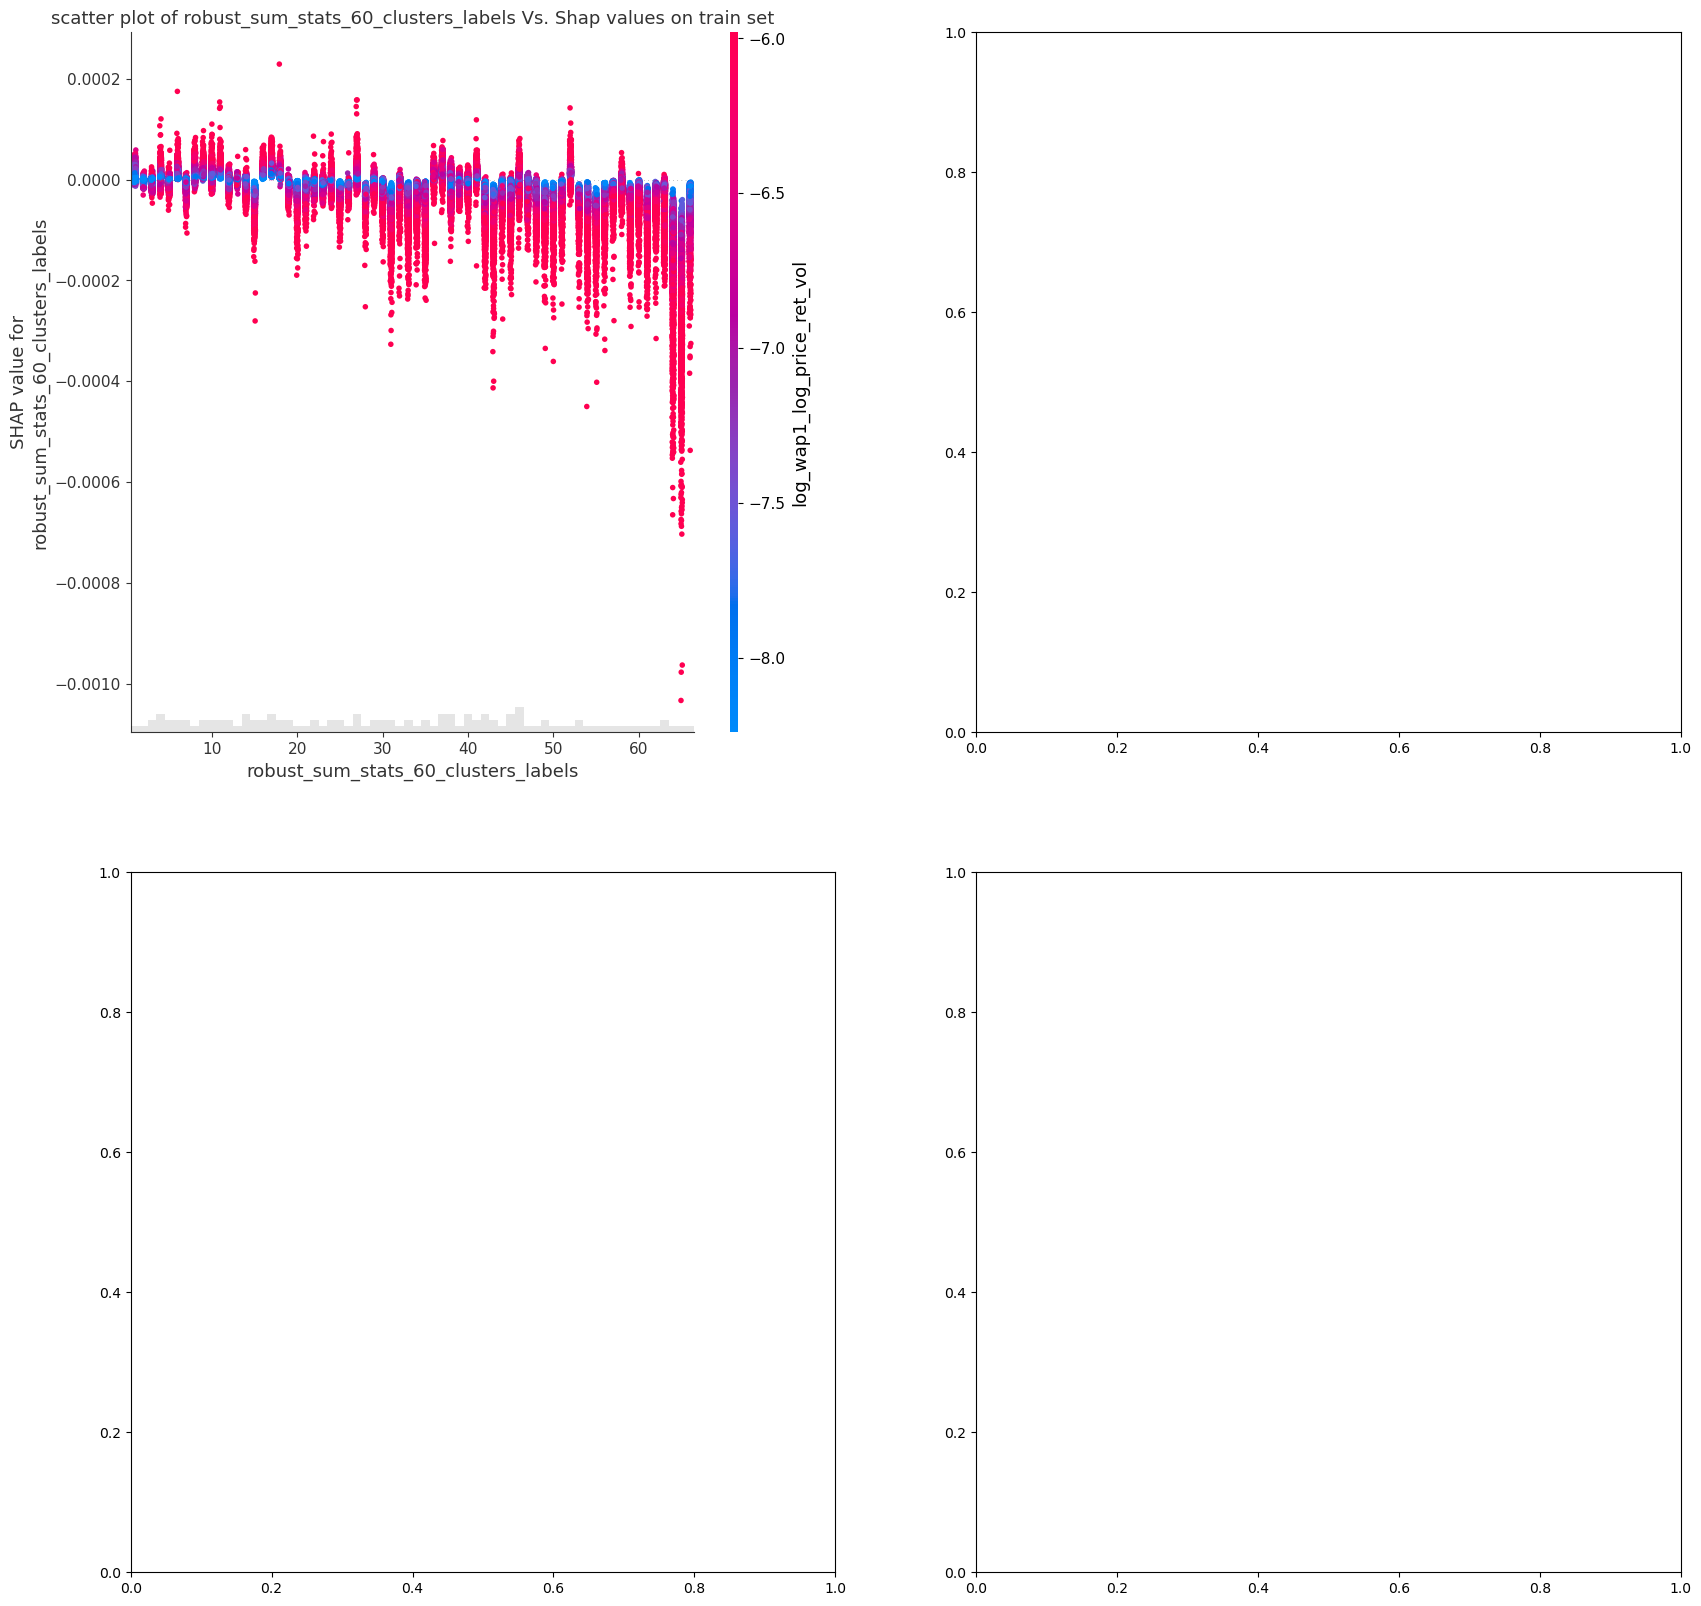

/home/optimusprime/miniconda3/envs/cuml_env/lib/python3.9/site-packages/shap/plots/_scatter.py:356: UserWarning:

Adding colorbar to a different Figure <Figure size 2000x2000 with 7 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.



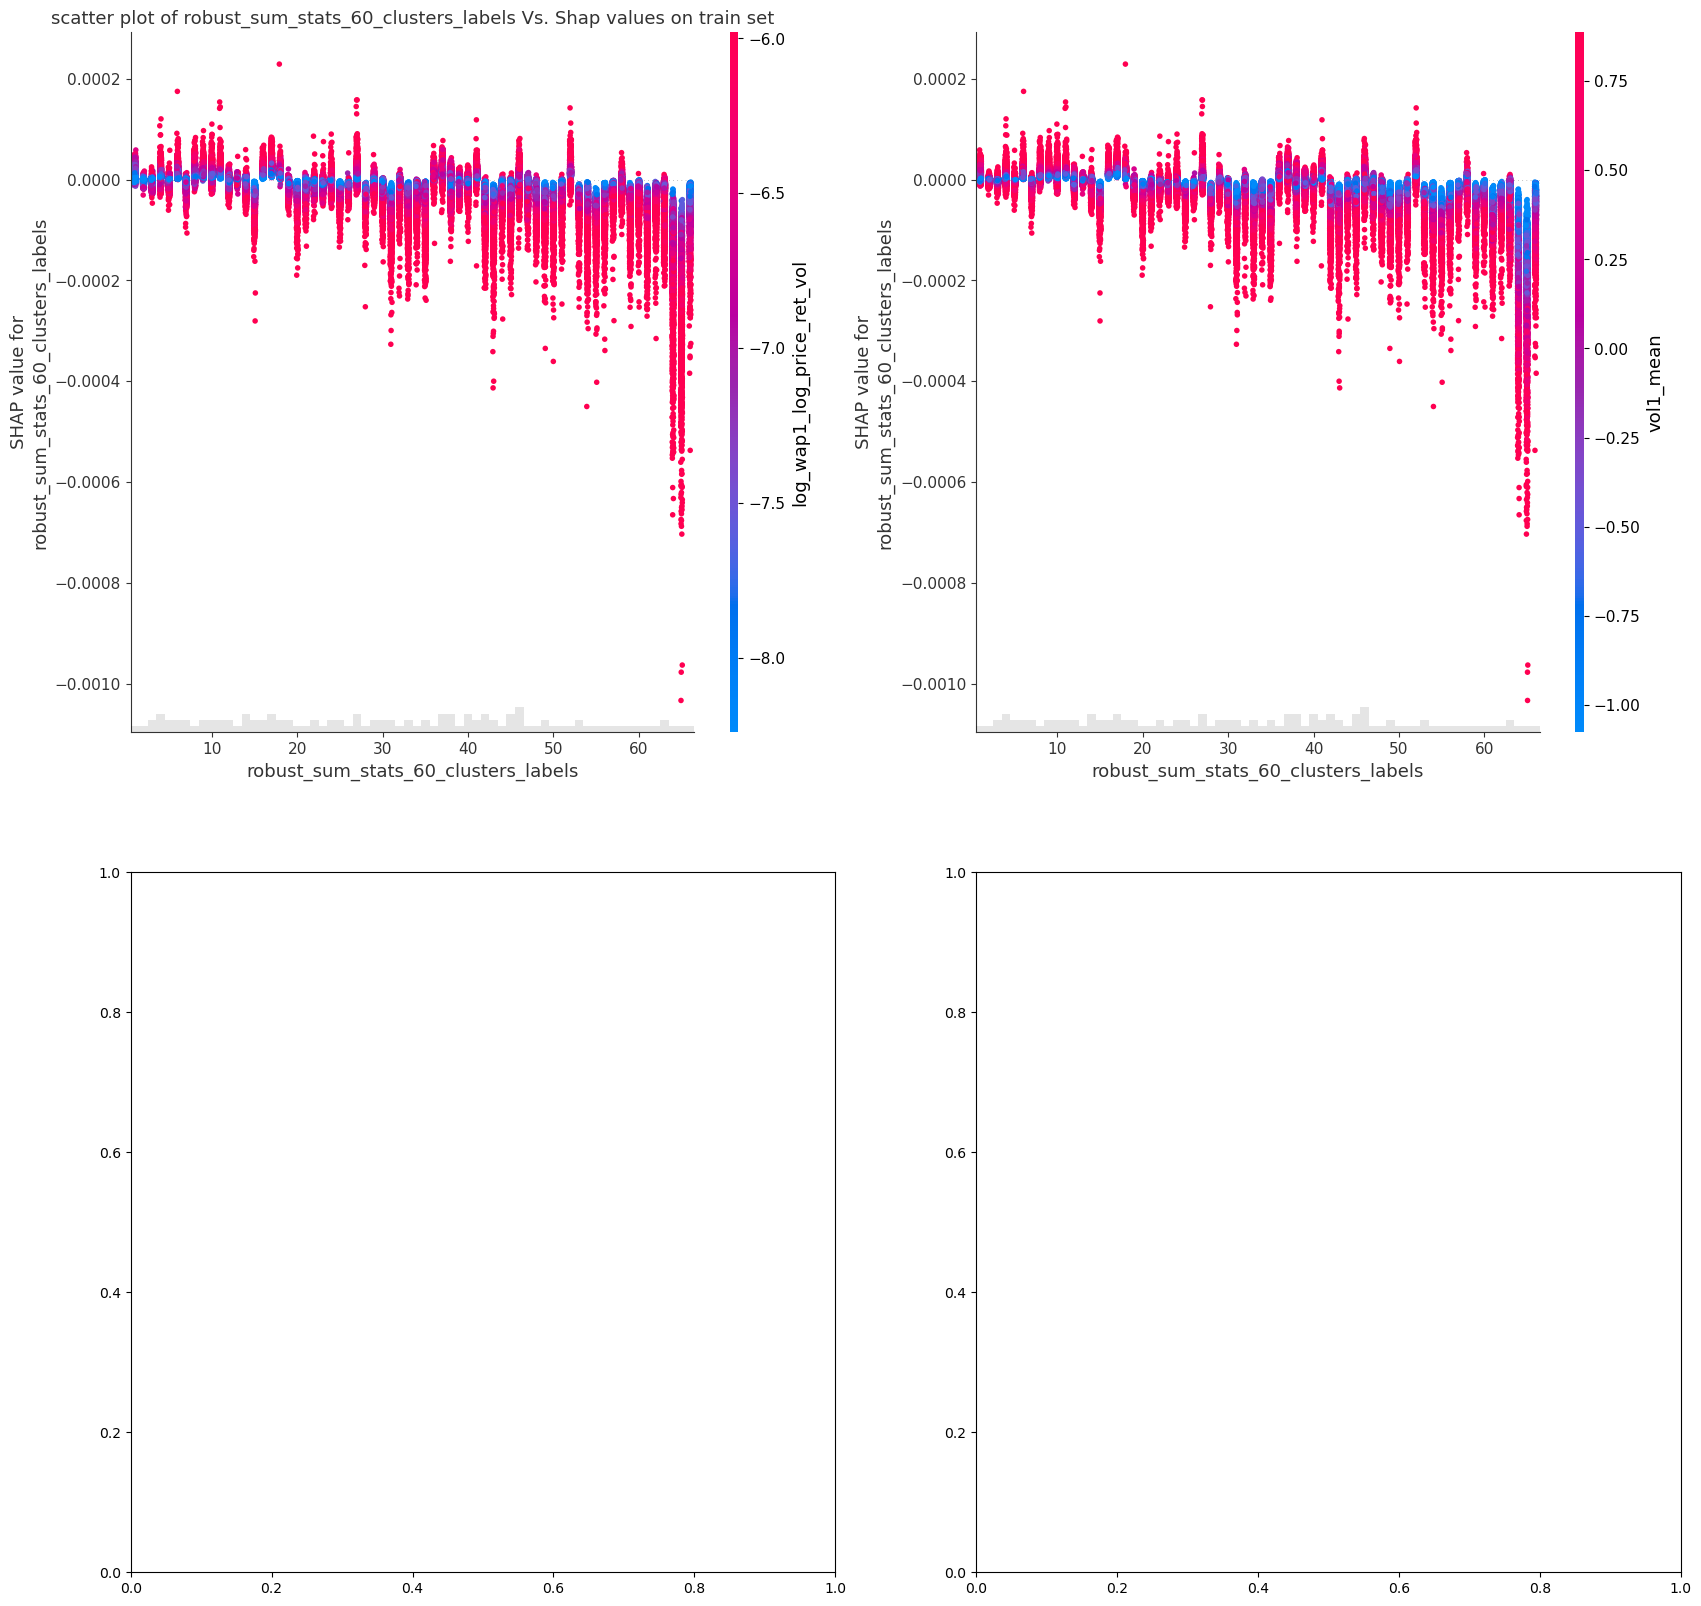

/home/optimusprime/miniconda3/envs/cuml_env/lib/python3.9/site-packages/shap/plots/_scatter.py:356: UserWarning:

Adding colorbar to a different Figure <Figure size 2000x2000 with 9 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.



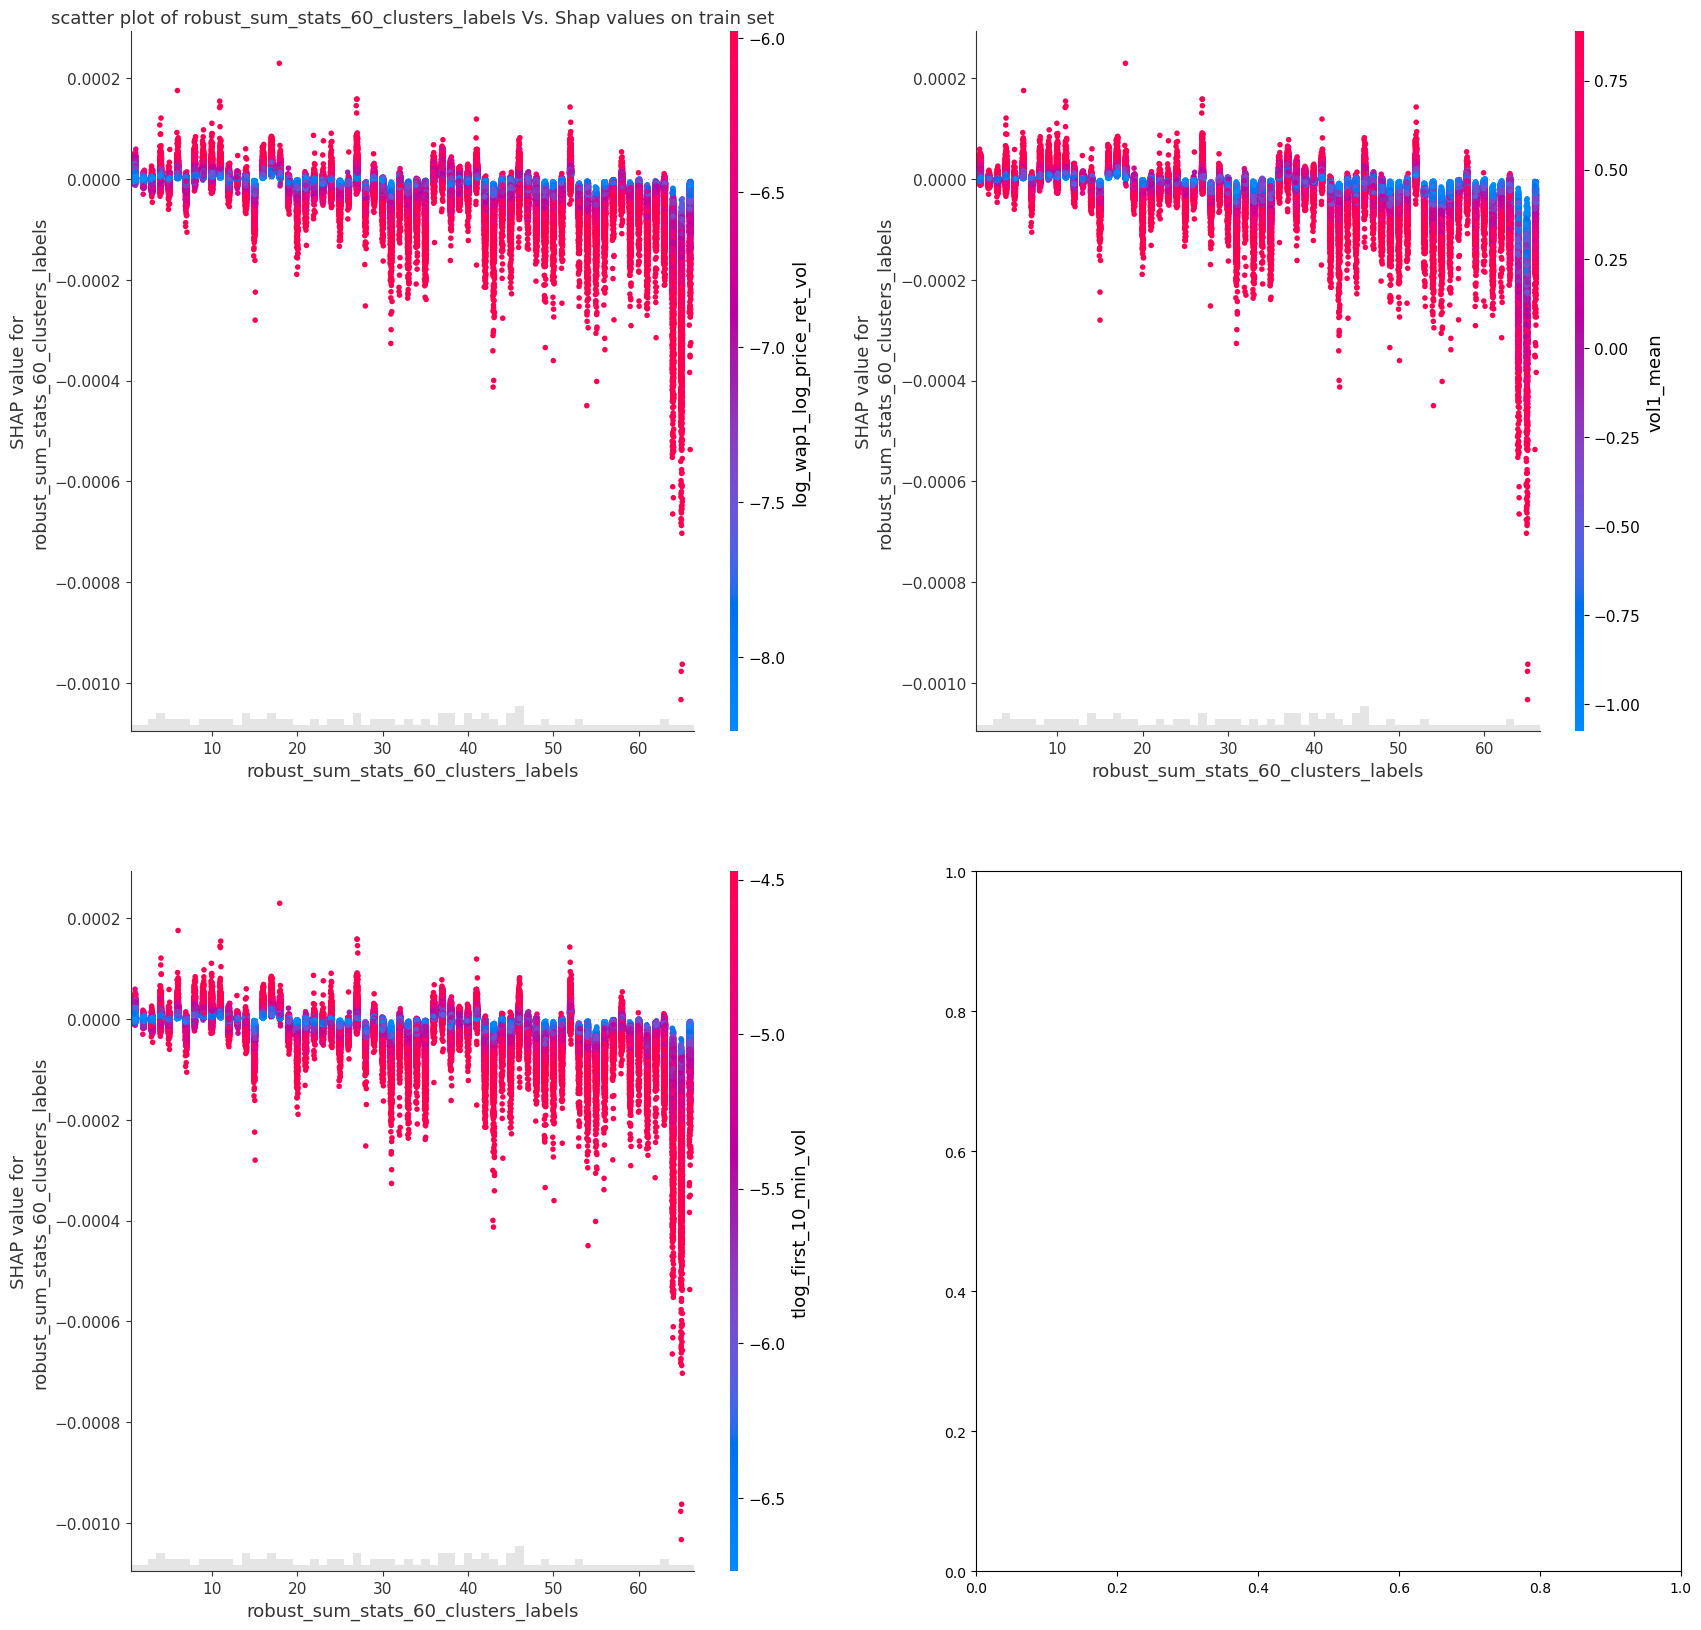


 scatter plot of robust_sum_stats_60_clusters_labels shap values vs. error
stock id: None, view_time_ids_start:  None, view_time_ids_end: None


ValueError: x and y must be the same size

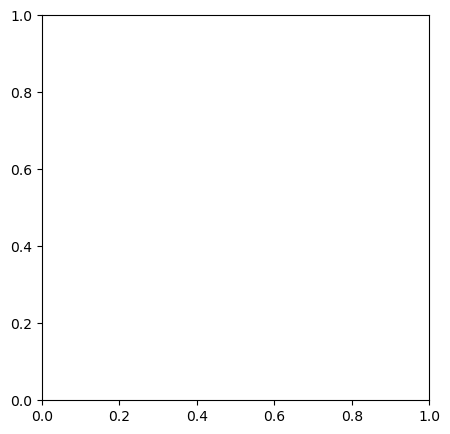

In [15]:
mean_val_set_rmspe_error = [ 0.226999,0.226498,0.226883]

train_shap_values_all, test_shap_values_all = t_v_t.evaluate_predictions(final_reg,test_pred, y_test_df,train_pred,y_train,X_train,X_test,v1tr,v1ts,w_train,w_test,best_mlxtend_RF_params,mean_val_set_rmspe_error)
